# Estimativa de pontos de estória usando aprendizado profundo

Utilização de aprendizado profundo por redes neurais.

In [86]:
import os
import math
import gzip
import pickle
import random

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

import spacy
import keras
import theano
from keras.layers import Input, Embedding, LSTM

from collections import defaultdict

#nlp = spacy.load('pt', disable=['parser', 'tagger', 'ner'])
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
#tokenizar = spacy.tokenizer.Tokenizer(nlp.vocab)

In [220]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [389]:
def save_to_pickle(data, file_path):
    with open(file_path,"wb") as file:
        pickle.dump(data, file)

def load_pickle(file_path):
    with open(file_path,"rb") as file:
        return pickle.load(file)

def print_log_out(string):
    print(string)
    with open('logs/main', "a+") as file:
        file.write(string+'\n')
        
def mascara_cubo_hipercubo(dim_entrada, dim_saida):
    mascara = np.zeros((dim_entrada, dim_saida))
    l2e = int(round(math.log2(dim_entrada)))
    qe = dim_entrada//l2e
    for i in range(qe): # dim_entrada > dim_saida
        mascara[(i*l2e):((i+1)*l2e), (i*l2e):((i+1)*l2e)] = 1
        for j in range(qe):
            mascara[i*l2e:(i+1)*l2e, l2e*(i^(1<<j)):l2e*((i^(1<<j))+1)] = 1
    return mascara

class CamadaHipercubo(keras.layers.Layer):
    def __init__(self, quant, **kwargs):
        self.quant = quant
        super(CamadaHipercubo, self).__init__(**kwargs)

    def build(self, dims_entrada):
        #ini = keras.initializers.random_uniform(minval=-0.1, maxval=1)
        self.mascara = keras.backend.constant(value=mascara_cubo_hipercubo(dims_entrada[1], self.quant))
        self.peso_W = self.add_weight(name='peso_W_hipercubo', shape=(dims_entrada[1], self.quant), initializer='uniform')
        self.peso_B = self.add_weight(name='peso_B_hipercubo', shape=(self.quant,), initializer='zeros')
        super(CamadaHipercubo, self).build(dims_entrada)

    def call(self, x):
        return keras.backend.relu(keras.backend.dot(x, self.peso_W * self.mascara) + self.peso_B)

    def compute_output_shape(self, dims_entrada):
        return (dims_entrada[0], self.quant)

class BiggerThanOneReg(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BiggerThanOneReg, self).__init__(**kwargs)

    def build(self, dims_entrada):
        self.one = keras.backend.constant(value=np.array([1]))
        #ini = keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.peso_W = self.add_weight(name='peso_W_bto', shape=(dims_entrada[1], 1), initializer='uniform')
        self.peso_B = self.add_weight(name='peso_B_bto', shape=(1,), initializer='ones')
        super(BiggerThanOneReg, self).build(dims_entrada)

    def call(self, x):
        return keras.backend.maximum(keras.backend.dot(x, self.peso_W) + self.peso_B, self.one)

    def compute_output_shape(self, dims_entrada):
        return (dims_entrada[0], 1)

## Divisão do conjunto de dados

Treino, validação e teste.

In [140]:
def ler_csv_texto_tokenizado(caminho_arquivo, tokenizador):
    tabela_dados = pd.read_csv(caminho_arquivo)
    titulos = tabela_dados.values[:, 1].astype('str')
    separadores = np.full(len(titulos), '. ')
    descricao = tabela_dados.values[:, 2].astype('str')
    valores = tabela_dados.values[:, 3].astype('float32')
    juntos = [a + b + c for a, b, c in zip(titulos, separadores, descricao)]
    tokenizados = [[w.text.strip().lower() for w in tokenizador(frase) if not w.text.isspace()] for frase in juntos]
    return tokenizados, valores

def gerar_dicionario(lista_tokens, vocabulario_maximo=2000):
    contagem = defaultdict(int)
    for tokens in lista_tokens:
        for token in tokens:
            contagem[token] += 1
    ordenadas = sorted(contagem.items(), key=lambda x: x[1], reverse=True)
    IDs = {'EOF_VALUE': 0, 'UNK_VALUE': 1}
    for i in range(min(vocabulario_maximo, len(ordenadas))): # EOF = 0, ID_desconhecido = 1
        IDs[ordenadas[i][0]] = i + 2
    return IDs

def converte_tokens_pretreino(lista_tokens, dic):
    dados = [np.array([(dic.get(tk) or 1) for tk in tks], dtype=np.int16) for tks in lista_tokens]
    return dados

def converte_tokens_treino(lista_tokens, dic, fracao_valida = 0.2, fracao_teste = 0.2, tamanho_frase=256):
    dados = np.zeros((len(lista_tokens), tamanho_frase), dtype='int16')
    for i, tks in enumerate(lista_tokens):
        compri = min(tamanho_frase, len(tks))
        dados[i, :compri] = [(dic.get(tks[i]) or 1) for i in range(compri)]
    quant_valida = int(fracao_valida * len(lista_tokens))
    quant_teste = int(fracao_teste * len(lista_tokens))
    return dados[:-quant_valida-quant_teste], dados[-quant_valida-quant_teste:-quant_teste], dados[-quant_teste:]

In [123]:
test_fraction = 0.2
val_fraction = 0.2

In [34]:
#a = ler_csv_texto_tokenizado('dados/pretreino/ccasj.csv', nlp.tokenizer)
unlabelled_words, _ = ler_csv_texto_tokenizado('dados/pretreino/lsscorp_pretreino.csv', nlp.tokenizer)
story_words, story_points = ler_csv_texto_tokenizado('dados/treino/datamanagement.csv', nlp.tokenizer)
num_test = int(round(len(story_words) * test_fraction))
num_val = int(round(len(story_words) * val_fraction))
num_train = len(story_words) - num_test - num_val
dic = gerar_dicionario(unlabelled_words + story_words[:num_train])

#treino, validacao = converte_tokens_pretreino(a, dic)
pretrain_tokens = converte_tokens_pretreino(unlabelled_words + story_words[:num_train], dic)
print('Vocabulario: ', len(dic), '\nTreino: ', len(pretrain_tokens))#, '\n Validação: ', len(validacao))

Vocabulario:  2002 
Treino:  5253


In [47]:
x_train, x_val, x_test = converte_tokens_treino(story_words, dic)
y_train = story_points[:x_train.shape[0]].reshape((-1, 1))
y_val = story_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
y_test = story_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))
print('Train: ', x_train.shape[0], '\nValidation: ', x_val.shape[0], '\nTest: ', x_test.shape[0])

Train:  2801 
Validation:  933 
Test:  933


In [56]:
np.sum(y_train>21)

319

In [219]:
np.mean(np.abs(np.median(y_train) - y_test))

6.19507

In [210]:
story_points_clip = {}
for p in project_repos.keys():
    f = gzip.open('dados/temp/%s.pkl.gz' % p, 'rb')

    train_t, train_d, train_y, \
    valid_t, valid_d, valid_y, \
    test_t, test_d, test_y = pickle.load(f, encoding='latin1')
    story_points_clip[p] = max(train_y.max(), valid_y.max(), test_y.max())
story_points_clip

{'mesos': 5.0,
 'usergrid': 5.0,
 'appceleratorstudio': 8.0,
 'aptanastudio': 13.0,
 'titanium': 13.0,
 'duracloud': 4.0,
 'bamboo': 5.0,
 'clover': 13.0,
 'jirasoftware': 8.0,
 'moodle': 40.0,
 'datamanagement': 21.0,
 'mule': 8.0,
 'mulestudio': 13.0,
 'springxd': 8.0,
 'talenddataquality': 13.0,
 'talendesb': 3.0}

In [204]:
with gzip.open('dados/temp/%s.pkl.gz' % 'datamanagement', 'rb') as f:
    train_t, train_d, train_y, \
    valid_t, valid_d, valid_y, \
    test_t, test_d, test_y = pickle.load(f, encoding='latin1')

In [209]:
min(1, 2, 3)

1

In [191]:
story_words, story_points = ler_csv_texto_tokenizado(train_data_path % 'mesos', nlp.tokenizer)

In [194]:
story_points[:train_y.shape[0]][train_y != story_points[:train_y.shape[0]]]

array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.,  8., 13., 40.,
        8.,  8.,  8.,  8., 13., 13.,  8.,  8., 13.,  8.,  8.,  8.,  8.,
        8., 13., 13.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 13.,  8., 13.,  8., 13., 13., 13.,  8.,  8., 13.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8., 13., 13.,  8., 13.,  8.,  8.,  8.,  8., 13.,  8.,
        6., 13.,  8.,  8., 13.,  8.,  8.,  8., 13., 13.,  8., 13., 13.,
       13., 13., 13.,  8.,  8.,  8., 10.], dtype=float32)

In [193]:
train_y

array([2., 5., 5., ..., 1., 1., 1.], dtype=float32)

## Pretreinamento

In [124]:
class GeradorDados(keras.utils.Sequence):
    
    def __init__(self, funcoes, tamanho_batch=128, quant_batch=100, janela=7, fracao_positiva=0.5):
        self.funcoes = funcoes
        self.tamanho_batch = tamanho_batch
        self.quant_batch = quant_batch
        self.janela = janela
        self.fracao_positiva = fracao_positiva
        self.quant_funcoes = len(funcoes)
    
    def __len__(self):
        return self.quant_batch
    
    def __getitem__(self, idx):
        alvo = np.zeros((self.tamanho_batch, 1), dtype='int16')
        contexto = np.zeros((self.tamanho_batch, 1), dtype='int16')
        verdade = np.zeros((self.tamanho_batch, 1))
        for i in range(self.tamanho_batch):
            positivo = random.random() < self.fracao_positiva
            j = random.randint(0, self.quant_funcoes - 1)
            k = random.randint(0, self.funcoes[j].shape[0] - 1)
            if positivo:
                l = j
                m = random.randint(max(0, k-self.janela), min(self.funcoes[j].shape[0] - 1, k+self.janela))
            else:
                l = random.randint(0, self.quant_funcoes - 1)
                m = random.randint(0, self.funcoes[l].shape[0] - 1)
            alvo[i] = self.funcoes[j][k]
            contexto[i] = self.funcoes[l][m]
            verdade[i] = positivo
        return [alvo, contexto], verdade

def gerar_modelo_keras(vocabulario, dimensao_vetorial=64):
    entrada_contexto = keras.layers.Input(shape=(1,), dtype='int16', name='palavra_contexto')
    entrada_alvo = keras.layers.Input(shape=(1,), dtype='int16', name='palavra_alvo')
    vetorizacao = keras.layers.Embedding(vocabulario, dimensao_vetorial, name='vetorizacao')
    contexto = keras.layers.Flatten()(vetorizacao(entrada_contexto))
    alvo = keras.layers.Flatten()(vetorizacao(entrada_alvo))
    produto_interno = keras.layers.dot([alvo, contexto], axes=-1)
    estimativa = keras.layers.Dense(1, activation='sigmoid')(produto_interno)
    return keras.models.Model(inputs=[entrada_alvo, entrada_contexto], outputs=estimativa)

In [39]:
gerador_treino = GeradorDados(pretrain_tokens, 128, 512)
gerador_valida = GeradorDados(pretrain_tokens, 128, 8)
mod_emb = gerar_modelo_keras(len(dic))
mod_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
palavra_alvo (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
palavra_contexto (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
vetorizacao (Embedding)         (None, 1, 50)        100100      palavra_contexto[0][0]           
                                                                 palavra_alvo[0][0]               
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 50)           0           vetorizacao[1][0]                
__________

In [40]:
mod_emb.compile(loss='binary_crossentropy',optimizer='adam')

In [37]:
keras.Model.fit_generator?

In [42]:
csv_logger = keras.callbacks.CSVLogger('logs/pretrain.log')
#parar_mlp = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
save_best = keras.callbacks.ModelCheckpoint('models/pretrain.h5', monitor='val_loss', mode='min', save_best_only=True)

historico3 = mod_emb.fit_generator(generator=gerador_treino, epochs=500, use_multiprocessing=True, shuffle=False, workers=32, max_queue_size=1024, validation_data=gerador_valida, callbacks=[csv_logger,save_best])

Epoch 1/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6537 - val_loss: 0.6402
Epoch 2/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6553 - val_loss: 0.6474
Epoch 3/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6528 - val_loss: 0.6450
Epoch 4/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6516 - val_loss: 0.6394
Epoch 5/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6492 - val_loss: 0.6539
Epoch 6/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6501 - val_loss: 0.6464
Epoch 7/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6474 - val_loss: 0.6554
Epoch 8/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6483 - val_loss: 0.6524
Epoch 9/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6472 - val_loss: 0.6383
Epoch 10/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6463 - val_lo

512/512 [==============================] - 3s 5ms/step - loss: 0.6291 - val_loss: 0.6166
Epoch 82/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6311 - val_loss: 0.6391
Epoch 83/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6300 - val_loss: 0.6248
Epoch 84/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6308 - val_loss: 0.6205
Epoch 85/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6311 - val_loss: 0.6353
Epoch 86/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6308 - val_loss: 0.6192
Epoch 87/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6296 - val_loss: 0.6349
Epoch 88/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6300 - val_loss: 0.6286
Epoch 89/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6294 - val_loss: 0.6457
Epoch 90/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6300 - val_loss: 

Epoch 161/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6279 - val_loss: 0.6295
Epoch 162/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6257 - val_loss: 0.6376
Epoch 163/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6275 - val_loss: 0.6261
Epoch 164/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6267 - val_loss: 0.6366
Epoch 165/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6270 - val_loss: 0.6256
Epoch 166/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6270 - val_loss: 0.6421
Epoch 167/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6277 - val_loss: 0.6308
Epoch 168/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6263 - val_loss: 0.6337
Epoch 169/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6255 - val_loss: 0.6239
Epoch 170/500
512/512 [==============================] - 2s 5ms/step - lo

512/512 [==============================] - 2s 4ms/step - loss: 0.6219 - val_loss: 0.6234
Epoch 241/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6243 - val_loss: 0.6355
Epoch 242/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6259 - val_loss: 0.6129
Epoch 243/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6230 - val_loss: 0.6193
Epoch 244/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6243 - val_loss: 0.6256
Epoch 245/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6259 - val_loss: 0.6400
Epoch 246/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6240 - val_loss: 0.6177
Epoch 247/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6254 - val_loss: 0.6324
Epoch 248/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6254 - val_loss: 0.6206
Epoch 249/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6254 - v

512/512 [==============================] - 2s 4ms/step - loss: 0.6237 - val_loss: 0.6314
Epoch 320/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6230 - val_loss: 0.6396
Epoch 321/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6254 - val_loss: 0.6436
Epoch 322/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6231 - val_loss: 0.6274
Epoch 323/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6220 - val_loss: 0.6354
Epoch 324/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6229 - val_loss: 0.6097
Epoch 325/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6231 - val_loss: 0.6167
Epoch 326/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6239 - val_loss: 0.6224
Epoch 327/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6244 - val_loss: 0.6226
Epoch 328/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6222 - v

512/512 [==============================] - 2s 5ms/step - loss: 0.6233 - val_loss: 0.6397
Epoch 399/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6208 - val_loss: 0.6272
Epoch 400/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6205 - val_loss: 0.6264
Epoch 401/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6229 - val_loss: 0.6361
Epoch 402/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6243 - val_loss: 0.6305
Epoch 403/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6192 - val_loss: 0.6141
Epoch 404/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6226 - val_loss: 0.6386
Epoch 405/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6217 - val_loss: 0.6234
Epoch 406/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6236 - val_loss: 0.6448
Epoch 407/500
512/512 [==============================] - 3s 5ms/step - loss: 0.6244 - v

512/512 [==============================] - 3s 5ms/step - loss: 0.6242 - val_loss: 0.6153
Epoch 478/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6200 - val_loss: 0.6272
Epoch 479/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6243 - val_loss: 0.6336
Epoch 480/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6217 - val_loss: 0.6416
Epoch 481/500
512/512 [==============================] - 2s 5ms/step - loss: 0.6244 - val_loss: 0.6414
Epoch 482/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6238 - val_loss: 0.6211
Epoch 483/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6226 - val_loss: 0.6120
Epoch 484/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6208 - val_loss: 0.6374
Epoch 485/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6223 - val_loss: 0.5999
Epoch 486/500
512/512 [==============================] - 2s 4ms/step - loss: 0.6199 - v

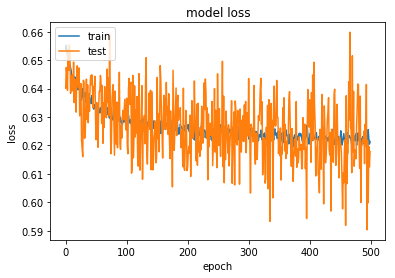

In [44]:
import matplotlib.pyplot as plt
plt.plot(historico3.history['loss'])
plt.plot(historico3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
t = mod_emb.get_layer('vetorizacao')

In [147]:
t.get_weights()[0].shape

(18268, 50)

In [169]:
mod_train.get_layer('emb_layer').set_weights(mod_emb.get_layer('vetorizacao').get_weights())

In [63]:
np.sqrt(np.sum(np.square(mod_emb.get_layer('vetorizacao').get_weights()[0])))

211.46341

In [66]:
np.sqrt(np.sum(np.square(mod_emb.get_layer('vetorizacao').get_weights()[0]-mod_train.get_layer('emb_layer').get_weights()[0])))

34.45888

In [387]:
def create_train_model(vocab_size, story_max_len = 256, emb_dim=64, num_lstm=64, num_relu1=32, num_relu2=16, num_relu3=8):
    input_layer = keras.layers.Input(shape=(story_max_len,), name='input_layer')
    X = keras.layers.Embedding(vocab_size, emb_dim, mask_zero=True, name='emb_layer')(input_layer)
    X = keras.layers.LSTM(num_lstm)(X)
    X = keras.layers.Dropout(0.3)(X)
    X = CamadaHipercubo(num_relu1)(X)
    X = keras.layers.Dropout(0.15)(X)
    X = CamadaHipercubo(num_relu2)(X)
    X = CamadaHipercubo(num_relu3)(X)
    X = CamadaHipercubo(4)(X)
    output_layer = BiggerThanOneReg()(X)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def initialize_train_model(model, emb_weights, bias=2):
    model.compile(loss='mae',optimizer='adam')
    model.get_layer('emb_layer').set_weights(emb_weights)
    #model.layers[-1].set_weights([mod_train.layers[-1].get_weights()[0], np.array([bias])])

In [ ]:
mod_train = create_train_model(len(dic))
initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights())

In [84]:
keras.callbacks.ModelCheckpoint?

In [109]:
print(a)

aasdfb


In [117]:
save_best = keras.callbacks.ModelCheckpoint('models/en/%s.h5' % 'train', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
log_csv = keras.callbacks.CSVLogger('logs/en/%s.log' % 'train')
hist_train = mod_train.fit(x_train, np.clip(y_train, 1, 21), epochs=20, validation_data=(x_val, np.clip(y_val, 1, 21)), callbacks=[save_best, log_csv])
save_to_pickle(hist_train, 'logs/en/%s.pkl' % 'train')

Train on 2801 samples, validate on 933 samples
Epoch 1/20
2801/2801 [==============================] - 21s 7ms/step - loss: 5.4544 - val_loss: 4.1005
Epoch 2/20
2801/2801 [==============================] - 20s 7ms/step - loss: 4.8522 - val_loss: 4.0385
Epoch 3/20
2801/2801 [==============================] - 20s 7ms/step - loss: 4.8460 - val_loss: 4.0358
Epoch 4/20
2801/2801 [==============================] - 21s 8ms/step - loss: 4.8548 - val_loss: 4.0358
Epoch 5/20
2801/2801 [==============================] - 21s 8ms/step - loss: 4.7948 - val_loss: 4.0095
Epoch 6/20
2801/2801 [==============================] - 22s 8ms/step - loss: 4.6346 - val_loss: 3.8592
Epoch 7/20
2801/2801 [==============================] - 22s 8ms/step - loss: 4.3234 - val_loss: 3.9890
Epoch 8/20
2801/2801 [==============================] - 22s 8ms/step - loss: 4.1086 - val_loss: 3.7309
Epoch 9/20
2801/2801 [==============================] - 21s 8ms/step - loss: 3.6655 - val_loss: 3.7230
Epoch 10/20
2801/2801 [===

TypeError: write() argument must be str, not bytes

In [119]:
save_to_pickle(hist_train, 'logs/en/%s.pkl' % 'train')

In [172]:
mod_train.evaluate(x_val, y_val)

933/933 [==============================] - 2s 2ms/step


212.65664538539875

In [194]:
mod_train = keras.models.load_model('models/train.h5')

In [78]:
predito = mod_train.predict(x_val)

In [80]:
np.sum(predito<1)

0

In [251]:
np.mean(np.abs(predito-y_val))

5.9249587

In [211]:
np.median(train_points)

4.0

In [212]:
np.mean(np.abs(np.mean(y_train)-y_test))

8.668086

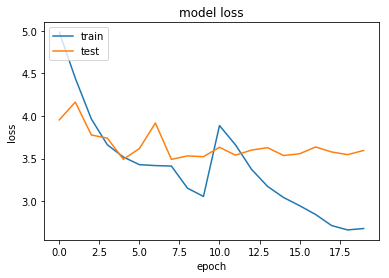

In [72]:
import matplotlib.pyplot as plt
plt.plot(hist_train.history['loss'])
plt.plot(hist_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loop

In [408]:
project_repos = {
    'mesos': 'apache',
    'usergrid': 'apache',
    'appceleratorstudio': 'appcelerator',
    'aptanastudio': 'appcelerator',
    'titanium': 'appcelerator',
    'duracloud': 'duraspace',
    'bamboo': 'jira',
    'clover': 'jira',
    'jirasoftware': 'jira',
    'moodle': 'moodle',
    'datamanagement': 'lsstcorp',
    'mule': 'mulesoft',
    'mulestudio': 'mulesoft',
    'springxd': 'spring',
    'talenddataquality': 'talendforge',
    'talendesb': 'talendforge'
}
story_points_clip = {
    'mesos': 5.0,
    'usergrid': 5.0,
    'appceleratorstudio': 8.0,
    'aptanastudio': 13.0,
    'titanium': 13.0,
    'duracloud': 4.0,
    'bamboo': 5.0,
    'clover': 13.0,
    'jirasoftware': 8.0,
    'moodle': 40.0,
    'datamanagement': 21.0,
    'mule': 8.0,
    'mulestudio': 13.0,
    'springxd': 8.0,
    'talenddataquality': 13.0,
    'talendesb': 3.0
}
deepse_baseline = {
    'mesos': 1.02,
    'usergrid': 1.03,
    'appceleratorstudio': 1.36,
    'aptanastudio': 2.71,
    'titanium': 1.97,
    'duracloud': 0.68,
    'bamboo': 0.74,
    'clover': 2.11,
    'jirasoftware': 1.38,
    'moodle': 5.97,
    'datamanagement': 3.77,
    'mule': 2.18,
    'mulestudio': 3.23,
    'springxd': 1.63,
    'talenddataquality': 2.97,
    'talendesb': 0.64
}
project_name = {
    'mesos': 'Mesos',
    'usergrid': 'Usergrid',
    'appceleratorstudio': 'Appcelerator Studio',
    'aptanastudio': 'Aptana Studio',
    'titanium': 'Titanium SDK/CLI',
    'duracloud': 'DuraCloud',
    'bamboo': 'Bamboo',
    'clover': 'Clover',
    'jirasoftware': 'Jira Software',
    'moodle': 'Moodle',
    'datamanagement': 'Data Management',
    'mule': 'Mule',
    'mulestudio': 'Mule Studio',
    'springxd': 'Spring XD',
    'talenddataquality': 'Talend Data Quality',
    'talendesb': 'Talend ESB'
}
repo_name = {
    'apache': 'Apache',
    'appcelerator': 'Appcelerator',
    'duraspace': 'DuraSpace',
    'jira': 'Atlassian',
    'moodle': 'Moodle',
    'lsstcorp': 'LSST Corporation',
    'mulesoft': 'MuleSoft',
    'spring': 'Spring',
    'talendforge': 'TalendForge'
}

In [ ]:
def pretrain(repo, pretrain_data_path, train_data_path, tokenizer, project_repos, dic_data_path, log_pre_data_path, model_data_path, hist_pre_data_path):
    unlabelled_words, _ = ler_csv_texto_tokenizado(pretrain_data_path % repo, tokenizer)
    for project in [k for k, v in project_repos.items() if v == repo]:
        story_words, _ = ler_csv_texto_tokenizado(train_data_path % project, tokenizer)
        num_test = int(round(len(story_words) * test_fraction))
        num_val = int(round(len(story_words) * val_fraction))
        num_train = len(story_words) - num_test - num_val
        unlabelled_words.extend(story_words[:num_train])
    dic = gerar_dicionario(unlabelled_words)
    save_to_pickle(dic, dic_data_path % repo)
    pretrain_tokens = converte_tokens_pretreino(unlabelled_words, dic)
    
    print_log_out("%s, %d" % (repo, len(pretrain_tokens)))

    gerador_treino = GeradorDados(pretrain_tokens, 128, 2048)
    gerador_valida = GeradorDados(pretrain_tokens, 128, 64)
    mod_emb = gerar_modelo_keras(len(dic))

    mod_emb.compile(loss='binary_crossentropy',optimizer='adam')

    log_csv = keras.callbacks.CSVLogger(log_pre_data_path % repo)
    save_best = keras.callbacks.ModelCheckpoint(model_pre_data_path % repo, monitor='val_loss', mode='min', save_best_only=True)
    hist_pretrain = mod_emb.fit_generator(generator=gerador_treino, epochs=500, use_multiprocessing=False, shuffle=False, max_queue_size=4096, validation_data=gerador_valida, callbacks=[save_best, log_csv])
    save_to_pickle(hist_pretrain.history, hist_pre_data_path % repo)
    
    return mod_emb

def train(train_data_path, dic_data_path, tokenizer, project_repos, log_data_path, model_data_path, hist_data_path):
    story_words, story_points = ler_csv_texto_tokenizado(train_data_path % project, tokenizer)
    dic = load_pickle(dic_data_path % project_repos[project])
    x_train, x_val, x_test = converte_tokens_treino(story_words, dic)
    y_train = story_points[:x_train.shape[0]].reshape((-1, 1))
    y_val = story_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
    y_test = story_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))
    
    print_log_out("%s, %d, %d" % (project, x_train.shape[0], x_val.shape[0]))

    mod_train = create_train_model(len(dic))
    mod_emb.load_weights(model_pre_data_path % project_repos[project])
    initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights())

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, min_delta=0)
    save_best = keras.callbacks.ModelCheckpoint(model_data_path % project, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    log_csv = keras.callbacks.CSVLogger(log_data_path % project)
    hist_train = mod_train.fit(x_train, np.clip(y_train, 1, story_points_clip[project]), epochs=40, validation_data=(x_val, np.clip(y_val, 1, story_points_clip[project])), callbacks=[save_best, log_csv, early_stopping])
    save_to_pickle(hist_train.history, hist_data_path % project)
    
    return mod_train

In [407]:
pretrain_data_path = 'data/pretrain/%s_pretrain.csv'
train_data_path = 'data/train/%s.csv'
dic_data_path = 'models/en/dic/%s.dic.pkl'
log_pre_data_path = 'logs/en/pretrain/%s.csv'
hist_pre_data_path = 'logs/en/pretrain/%s.pkl'
model_pre_data_path = 'models/en/pretrain/%s.h5'
log_data_path = 'logs/en/train/%s.csv'
hist_data_path = 'logs/en/train/%s.pkl'
model_data_path = 'models/en/train/%s.h5'

for repo in set(project_repos.values()):
    unlabelled_words, _ = ler_csv_texto_tokenizado(pretrain_data_path % repo, nlp.tokenizer)
    for project in [k for k, v in project_repos.items() if v == repo]:
        story_words, _ = ler_csv_texto_tokenizado(train_data_path % project, nlp.tokenizer)
        num_test = int(round(len(story_words) * test_fraction))
        num_val = int(round(len(story_words) * val_fraction))
        num_train = len(story_words) - num_test - num_val
        unlabelled_words.extend(story_words[:num_train])
    dic = gerar_dicionario(unlabelled_words)
    save_to_pickle(dic, dic_data_path % repo)
    pretrain_tokens = converte_tokens_pretreino(unlabelled_words, dic)
    
    print_log_out("%s, %d" % (repo, len(pretrain_tokens)))

    gerador_treino = GeradorDados(pretrain_tokens, 128, 2048)
    gerador_valida = GeradorDados(pretrain_tokens, 128, 64)
    mod_emb = gerar_modelo_keras(len(dic))

    mod_emb.compile(loss='binary_crossentropy',optimizer='adam')

    log_csv = keras.callbacks.CSVLogger(log_pre_data_path % repo)
    save_best = keras.callbacks.ModelCheckpoint(model_pre_data_path % repo, monitor='val_loss', mode='min', save_best_only=True)
    hist_pretrain = mod_emb.fit_generator(generator=gerador_treino, epochs=500, use_multiprocessing=False, shuffle=False, max_queue_size=4096, validation_data=gerador_valida, callbacks=[save_best, log_csv])
    save_to_pickle(hist_pretrain.history, hist_pre_data_path % repo)

    
for project in project_repos.keys():
    story_words, story_points = ler_csv_texto_tokenizado(train_data_path % project, nlp.tokenizer)
    dic = load_pickle(dic_data_path % project_repos[project])
    x_train, x_val, x_test = converte_tokens_treino(story_words, dic)
    y_train = story_points[:x_train.shape[0]].reshape((-1, 1))
    y_val = story_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
    y_test = story_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))
    
    print_log_out("%s, %d, %d" % (project, x_train.shape[0], x_val.shape[0]))

    mod_train = create_train_model(len(dic))
    mod_emb.load_weights(model_pre_data_path % project_repos[project])
    initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights())

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, min_delta=0)
    save_best = keras.callbacks.ModelCheckpoint(model_data_path % project, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    log_csv = keras.callbacks.CSVLogger(log_data_path % project)
    hist_train = mod_train.fit(x_train, np.clip(y_train, 1, story_points_clip[project]), epochs=40, validation_data=(x_val, np.clip(y_val, 1, story_points_clip[project])), callbacks=[save_best, log_csv, early_stopping])
    save_to_pickle(hist_train.history, hist_data_path % project)

ccasj, 17224
Epoch 1/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6820 - val_loss: 0.6630
Epoch 2/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6533 - val_loss: 0.6512
Epoch 3/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6437 - val_loss: 0.6391
Epoch 4/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6375 - val_loss: 0.6376
Epoch 5/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6343 - val_loss: 0.6344
Epoch 6/500
 129/2048 [>.............................] - ETA: 55s - loss: 0.6351 

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109325). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6331 - val_loss: 0.6348
Epoch 7/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6317 - val_loss: 0.6331
Epoch 8/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6292 - val_loss: 0.6260
Epoch 9/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6285 - val_loss: 0.6253
Epoch 10/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6287 - val_loss: 0.6315
Epoch 11/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6267 - val_loss: 0.6248
Epoch 12/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6263 - val_loss: 0.6289
Epoch 13/500
  89/2048 [>.............................] - ETA: 1:16 - loss: 0.6245

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101384). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6255 - val_loss: 0.6350
Epoch 14/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6248 - val_loss: 0.6298
Epoch 15/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6246 - val_loss: 0.6233
Epoch 16/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6237 - val_loss: 0.6251
Epoch 17/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6236 - val_loss: 0.6214
Epoch 18/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6224 - val_loss: 0.6281
Epoch 19/500
  13/2048 [..............................] - ETA: 6:09 - loss: 0.6123

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102637). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100640). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106133). Check your callbacks.
  % delta_t_median)


  60/2048 [..............................] - ETA: 1:45 - loss: 0.6201

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108706). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108312). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6228 - val_loss: 0.6158
Epoch 20/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6225 - val_loss: 0.6227
Epoch 21/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6218 - val_loss: 0.6222
Epoch 22/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6216 - val_loss: 0.6175
Epoch 23/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6213 - val_loss: 0.6216
Epoch 24/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6204 - val_loss: 0.6227
Epoch 25/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6217 - val_loss: 0.6201
Epoch 26/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6217 - val_loss: 0.6228
Epoch 27/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6194 - val_loss: 0.6206
Epoch 28/500
2048/2048 [==============================] - 8s 4ms/step - loss

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116906). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135468). Check your callbacks.
  % delta_t_median)


  87/2048 [>.............................] - ETA: 1:16 - loss: 0.6183

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127561). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6173 - val_loss: 0.6187
Epoch 42/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6171 - val_loss: 0.6254
Epoch 43/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6178 - val_loss: 0.6141
Epoch 44/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6175 - val_loss: 0.6210
Epoch 45/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6194 - val_loss: 0.6119
Epoch 46/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6169 - val_loss: 0.6146
Epoch 47/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6170 - val_loss: 0.6215
Epoch 48/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6169 - val_loss: 0.6179
Epoch 49/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6170 - val_loss: 0.6145
Epoch 50/500
   8/2048 [..............................] - ETA: 2:05 - loss: 

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111193). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6171 - val_loss: 0.6137
Epoch 51/500
   7/2048 [..............................] - ETA: 2:12 - loss: 0.6056

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109736). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104735). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 10s 5ms/step - loss: 0.6168 - val_loss: 0.6142
Epoch 52/500
  56/2048 [..............................] - ETA: 2:21 - loss: 0.6192

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100080). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6174 - val_loss: 0.6217
Epoch 53/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6179 - val_loss: 0.6141
Epoch 54/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6165 - val_loss: 0.6198
Epoch 55/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6151 - val_loss: 0.6148
Epoch 56/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6166 - val_loss: 0.6187
Epoch 57/500
  23/2048 [..............................] - ETA: 5:01 - loss: 0.6306

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102588). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6166 - val_loss: 0.6140
Epoch 58/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6155 - val_loss: 0.6129
Epoch 59/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6162 - val_loss: 0.6219
Epoch 60/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6170 - val_loss: 0.6131
Epoch 61/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6163 - val_loss: 0.6138
Epoch 62/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6169 - val_loss: 0.6141
Epoch 63/500
  39/2048 [..............................] - ETA: 3:15 - loss: 0.6164

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114574). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121607). Check your callbacks.
  % delta_t_median)


 110/2048 [>.............................] - ETA: 1:10 - loss: 0.6148

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110313). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 10s 5ms/step - loss: 0.6155 - val_loss: 0.6152
Epoch 64/500
2048/2048 [==============================] - 4s 2ms/step - loss: 0.6170 - val_loss: 0.6160
Epoch 65/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6146 - val_loss: 0.6230
Epoch 66/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6171 - val_loss: 0.6111
Epoch 67/500
2048/2048 [==============================] - 4s 2ms/step - loss: 0.6156 - val_loss: 0.6162
Epoch 68/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6164 - val_loss: 0.6124
Epoch 69/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6155 - val_loss: 0.6182
Epoch 70/500
  23/2048 [..............................] - ETA: 2:00 - loss: 0.6151

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110078). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6155 - val_loss: 0.6206
Epoch 71/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6153 - val_loss: 0.6137
Epoch 72/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6155 - val_loss: 0.6084
Epoch 73/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6149 - val_loss: 0.6178
Epoch 74/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6158 - val_loss: 0.6174
Epoch 75/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6153 - val_loss: 0.6217
Epoch 76/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6159 - val_loss: 0.6151
Epoch 77/500
 111/2048 [>.............................] - ETA: 1:14 - loss: 0.6148

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135344). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6155 - val_loss: 0.6090
Epoch 78/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6155 - val_loss: 0.6131
Epoch 79/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6151 - val_loss: 0.6139
Epoch 80/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6153 - val_loss: 0.6145
Epoch 81/500
 191/2048 [=>............................] - ETA: 42s - loss: 0.6116

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100096). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6151 - val_loss: 0.6172
Epoch 82/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6153 - val_loss: 0.6114
Epoch 83/500
  20/2048 [..............................] - ETA: 4:30 - loss: 0.6049

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104566). Check your callbacks.
  % delta_t_median)


  88/2048 [>.............................] - ETA: 1:17 - loss: 0.6102

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104228). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6155 - val_loss: 0.6191
Epoch 84/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6151 - val_loss: 0.6095
Epoch 85/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6141 - val_loss: 0.6139
Epoch 86/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6148 - val_loss: 0.6106
Epoch 87/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6154 - val_loss: 0.6212
Epoch 88/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6144 - val_loss: 0.6232
Epoch 89/500
2048/2048 [==============================] - ETA: 0s - loss: 0.614 - 10s 5ms/step - loss: 0.6148 - val_loss: 0.6211
Epoch 90/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6141 - val_loss: 0.6052
Epoch 91/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6138 - val_loss: 0.6171
Epoch 92/500
2048/2048 [=========================

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102904). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6140 - val_loss: 0.6098
Epoch 96/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6134 - val_loss: 0.6156
Epoch 97/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6147 - val_loss: 0.6140
Epoch 98/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6149 - val_loss: 0.6090
Epoch 99/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6135 - val_loss: 0.6146
Epoch 100/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6146 - val_loss: 0.6168
Epoch 101/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6138 - val_loss: 0.6188
Epoch 102/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6141 - val_loss: 0.6136
Epoch 103/500
  31/2048 [..............................] - ETA: 2:42 - loss: 0.6085

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100879). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6151 - val_loss: 0.6208
Epoch 104/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6134 - val_loss: 0.6076
Epoch 105/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6125 - val_loss: 0.6148
Epoch 106/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6148 - val_loss: 0.6093
Epoch 107/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6150 - val_loss: 0.6139
Epoch 108/500
  10/2048 [..............................] - ETA: 8:06 - loss: 0.6090

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110692). Check your callbacks.
  % delta_t_median)


  58/2048 [..............................] - ETA: 1:42 - loss: 0.6108

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111929). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108266). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 3ms/step - loss: 0.6141 - val_loss: 0.6073
Epoch 109/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6149 - val_loss: 0.6153
Epoch 110/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6146 - val_loss: 0.6134
Epoch 111/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6137 - val_loss: 0.6088
Epoch 112/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6143 - val_loss: 0.6174
Epoch 113/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6136 - val_loss: 0.6176
Epoch 114/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6131 - val_loss: 0.6181
Epoch 115/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6132 - val_loss: 0.6216
Epoch 116/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6142 - val_loss: 0.6149
Epoch 117/500
2048/2048 [==============================] - 9s 4ms/st

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113690). Check your callbacks.
  % delta_t_median)


 141/2048 [=>............................] - ETA: 48s - loss: 0.6143

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125619). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144974). Check your callbacks.
  % delta_t_median)


 187/2048 [=>............................] - ETA: 42s - loss: 0.6145

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123931). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100830). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6145 - val_loss: 0.6169
Epoch 119/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6129 - val_loss: 0.6188
Epoch 120/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6141 - val_loss: 0.6141
Epoch 121/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6121 - val_loss: 0.6097
Epoch 122/500
  23/2048 [..............................] - ETA: 3:39 - loss: 0.6152

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102686). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104573). Check your callbacks.
  % delta_t_median)


  42/2048 [..............................] - ETA: 2:52 - loss: 0.6168

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101251). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6144 - val_loss: 0.6114
Epoch 123/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6131 - val_loss: 0.6127
Epoch 124/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6138 - val_loss: 0.6139
Epoch 125/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6129 - val_loss: 0.6223
Epoch 126/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6134 - val_loss: 0.6121
Epoch 127/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6131 - val_loss: 0.6097
Epoch 128/500
  66/2048 [..............................] - ETA: 1:45 - loss: 0.6101

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102555). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6120 - val_loss: 0.6150
Epoch 129/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6138 - val_loss: 0.6155
Epoch 130/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6129 - val_loss: 0.6192
Epoch 131/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6122 - val_loss: 0.6129
Epoch 132/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6137 - val_loss: 0.6126
Epoch 133/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6144 - val_loss: 0.6141
Epoch 134/500
 178/2048 [=>............................] - ETA: 48s - loss: 0.6081

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107599). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109004). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6122 - val_loss: 0.6183
Epoch 135/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6131 - val_loss: 0.6170
Epoch 136/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6131 - val_loss: 0.6143
Epoch 137/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6128 - val_loss: 0.6185
Epoch 138/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6135 - val_loss: 0.6093
Epoch 139/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6126 - val_loss: 0.6082
Epoch 140/500
  68/2048 [..............................] - ETA: 1:40 - loss: 0.6140

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105462). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6127 - val_loss: 0.6162
Epoch 141/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6133 - val_loss: 0.6090
Epoch 142/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6121 - val_loss: 0.6100
Epoch 143/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6128 - val_loss: 0.6169
Epoch 144/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6123 - val_loss: 0.6185
Epoch 145/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6127 - val_loss: 0.6177
Epoch 146/500
   3/2048 [..............................] - ETA: 3:42 - loss: 0.6898

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114491). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6136 - val_loss: 0.6199
Epoch 147/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6132 - val_loss: 0.6092
Epoch 148/500
  76/2048 [>.............................] - ETA: 1:33 - loss: 0.6136

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105454). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104010). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6125 - val_loss: 0.6123
Epoch 149/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6203
Epoch 150/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6108
Epoch 151/500
  26/2048 [..............................] - ETA: 4:46 - loss: 0.6118

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104938). Check your callbacks.
  % delta_t_median)


  72/2048 [>.............................] - ETA: 1:50 - loss: 0.6086

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106555). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6126 - val_loss: 0.6146
Epoch 152/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6131 - val_loss: 0.6124
Epoch 153/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6124 - val_loss: 0.6128
Epoch 154/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6122 - val_loss: 0.6161
Epoch 155/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6164
Epoch 156/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6124 - val_loss: 0.6105
Epoch 157/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6127 - val_loss: 0.6068
Epoch 158/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6131 - val_loss: 0.6074
Epoch 159/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6128 - val_loss: 0.6092
Epoch 160/500
2048/2048 [==============================] - 8s 4ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101998). Check your callbacks.
  % delta_t_median)


  62/2048 [..............................] - ETA: 1:45 - loss: 0.6102

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111625). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6120 - val_loss: 0.6189
Epoch 162/500
  15/2048 [..............................] - ETA: 6:04 - loss: 0.6097

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105687). Check your callbacks.
  % delta_t_median)


  52/2048 [..............................] - ETA: 2:01 - loss: 0.6141

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107587). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103767). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6138 - val_loss: 0.6174
Epoch 163/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6129 - val_loss: 0.6147
Epoch 164/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6123 - val_loss: 0.6135
Epoch 165/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6116 - val_loss: 0.6147
Epoch 166/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6128 - val_loss: 0.6190
Epoch 167/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6131 - val_loss: 0.6088
Epoch 168/500
   7/2048 [..............................] - ETA: 6:30 - loss: 0.6127

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137062). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155058). Check your callbacks.
  % delta_t_median)


  59/2048 [..............................] - ETA: 1:45 - loss: 0.6119

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173054). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187202). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6132 - val_loss: 0.6095
Epoch 169/500
2048/2048 [==============================] - 6s 3ms/step - loss: 0.6128 - val_loss: 0.6106
Epoch 170/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6124 - val_loss: 0.6122
Epoch 171/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6122 - val_loss: 0.6079
Epoch 172/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6129 - val_loss: 0.6155
Epoch 173/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6195
Epoch 174/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6127 - val_loss: 0.6142
Epoch 175/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6120 - val_loss: 0.6164
Epoch 176/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6129 - val_loss: 0.6066
Epoch 177/500
2048/2048 [==============================] - 8s 4ms/ste

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101918). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104545). Check your callbacks.
  % delta_t_median)


  55/2048 [..............................] - ETA: 2:10 - loss: 0.6161

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107428). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102585). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6137 - val_loss: 0.6126
Epoch 180/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6119 - val_loss: 0.6168
Epoch 181/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6125 - val_loss: 0.6134
Epoch 182/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6128 - val_loss: 0.6126
Epoch 183/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6117 - val_loss: 0.6049
Epoch 184/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6134
Epoch 185/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6134 - val_loss: 0.6158
Epoch 186/500
2048/2048 [==============================] - 5s 3ms/step - loss: 0.6129 - val_loss: 0.6092
Epoch 187/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6120 - val_loss: 0.6145
Epoch 188/500
2048/2048 [==============================] - 10s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.644069). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.834160). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 5ms/step - loss: 0.6125 - val_loss: 0.6163
Epoch 193/500
2048/2048 [==============================] - 7s 3ms/step - loss: 0.6124 - val_loss: 0.6103
Epoch 194/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6113 - val_loss: 0.6145
Epoch 195/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6129 - val_loss: 0.6103
Epoch 196/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6122 - val_loss: 0.6087
Epoch 197/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6128 - val_loss: 0.6190
Epoch 198/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6113 - val_loss: 0.6080
Epoch 199/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6119 - val_loss: 0.6117
Epoch 200/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6114 - val_loss: 0.6113
Epoch 201/500
  77/2048 [>.............................] - ETA: 1:2

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107530). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6122 - val_loss: 0.6160
Epoch 202/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6110 - val_loss: 0.6130
Epoch 203/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6104 - val_loss: 0.6080
Epoch 204/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6113 - val_loss: 0.6132
Epoch 205/500
  12/2048 [..............................] - ETA: 5:42 - loss: 0.6200

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105380). Check your callbacks.
  % delta_t_median)


  14/2048 [..............................] - ETA: 6:57 - loss: 0.6145

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116733). Check your callbacks.
  % delta_t_median)


  76/2048 [>.............................] - ETA: 1:25 - loss: 0.6103

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110744). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102623). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6122 - val_loss: 0.6157
Epoch 206/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6126 - val_loss: 0.6124
Epoch 207/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6118 - val_loss: 0.6113
Epoch 208/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6125 - val_loss: 0.6114
Epoch 209/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6127 - val_loss: 0.6151
Epoch 210/500
  19/2048 [..............................] - ETA: 4:51 - loss: 0.6239

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113414). Check your callbacks.
  % delta_t_median)


  21/2048 [..............................] - ETA: 5:06 - loss: 0.6248

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103483). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6103 - val_loss: 0.6108
Epoch 211/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6128 - val_loss: 0.6154
Epoch 212/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6121 - val_loss: 0.6127
Epoch 213/500
  17/2048 [..............................] - ETA: 5:05 - loss: 0.6180

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187376). Check your callbacks.
  % delta_t_median)


  68/2048 [..............................] - ETA: 1:32 - loss: 0.6118

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147471). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101628). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 3ms/step - loss: 0.6115 - val_loss: 0.6090
Epoch 214/500
  39/2048 [..............................] - ETA: 3:01 - loss: 0.6129

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102511). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104518). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6113 - val_loss: 0.6185
Epoch 215/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6119 - val_loss: 0.6167
Epoch 216/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6109 - val_loss: 0.6109
Epoch 217/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6084
Epoch 218/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6107 - val_loss: 0.6058
Epoch 219/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6118 - val_loss: 0.6115
Epoch 220/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6108 - val_loss: 0.6125
Epoch 221/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6109 - val_loss: 0.6123
Epoch 222/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6119 - val_loss: 0.6131
Epoch 223/500
2048/2048 [==============================] - 9s 5ms/st

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100303). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6123 - val_loss: 0.6157
Epoch 231/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6092
Epoch 232/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6140 - val_loss: 0.6065
Epoch 233/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6120 - val_loss: 0.6070
Epoch 234/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6110 - val_loss: 0.6142
Epoch 235/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6110 - val_loss: 0.6107
Epoch 236/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6123 - val_loss: 0.6195
Epoch 237/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6113 - val_loss: 0.6102
Epoch 238/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6123 - val_loss: 0.6083
Epoch 239/500
2048/2048 [==============================] - 11s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100341). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104384). Check your callbacks.
  % delta_t_median)


  13/2048 [..............................] - ETA: 5:55 - loss: 0.6231

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108264). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101560). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 10s 5ms/step - loss: 0.6122 - val_loss: 0.6217
Epoch 251/500
2048/2048 [==============================] - 6s 3ms/step - loss: 0.6122 - val_loss: 0.6114
Epoch 252/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6102 - val_loss: 0.6143
Epoch 253/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6115 - val_loss: 0.6122
Epoch 254/500
  24/2048 [..............................] - ETA: 4:03 - loss: 0.6096

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102883). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6123 - val_loss: 0.6122
Epoch 255/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6121 - val_loss: 0.6179
Epoch 256/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6129
Epoch 257/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6109 - val_loss: 0.6126
Epoch 258/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6116 - val_loss: 0.6110
Epoch 259/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6116 - val_loss: 0.6108
Epoch 260/500
  69/2048 [>.............................] - ETA: 2:19 - loss: 0.6119

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104138). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6111 - val_loss: 0.6156
Epoch 261/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6111 - val_loss: 0.6148
Epoch 262/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6123 - val_loss: 0.6032
Epoch 263/500
  25/2048 [..............................] - ETA: 4:08 - loss: 0.6060- ETA: 2:06 - l

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135224). Check your callbacks.
  % delta_t_median)


  56/2048 [..............................] - ETA: 2:10 - loss: 0.6096

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106378). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6111 - val_loss: 0.6136
Epoch 264/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6107 - val_loss: 0.6123
Epoch 265/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6111
Epoch 266/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6114 - val_loss: 0.6128
Epoch 267/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6119 - val_loss: 0.6188
Epoch 268/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6114 - val_loss: 0.6057
Epoch 269/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6110 - val_loss: 0.6136
Epoch 270/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6118 - val_loss: 0.6128
Epoch 271/500
 202/2048 [=>............................] - ETA: 40s - loss: 0.6106

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104954). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6104 - val_loss: 0.6146
Epoch 272/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6126 - val_loss: 0.6159
Epoch 273/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6109 - val_loss: 0.6024
Epoch 274/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6123 - val_loss: 0.6109
Epoch 275/500
  50/2048 [..............................] - ETA: 11s - loss: 0.6099

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117579). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 4s 2ms/step - loss: 0.6115 - val_loss: 0.6141
Epoch 276/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6118 - val_loss: 0.6143
Epoch 277/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6118 - val_loss: 0.6129
Epoch 278/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6114 - val_loss: 0.6105
Epoch 279/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6112 - val_loss: 0.6117
Epoch 280/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6114 - val_loss: 0.6096
Epoch 281/500
2048/2048 [==============================] - 7s 3ms/step - loss: 0.6110 - val_loss: 0.6112
Epoch 282/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6101 - val_loss: 0.6082
Epoch 283/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6110 - val_loss: 0.6080
Epoch 284/500
2048/2048 [==============================] - 10s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109591). Check your callbacks.
  % delta_t_median)


  16/2048 [..............................] - ETA: 5:42 - loss: 0.6218

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119356). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114692). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108273). Check your callbacks.
  % delta_t_median)


  70/2048 [>.............................] - ETA: 1:36 - loss: 0.6173

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115463). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6118 - val_loss: 0.6076
Epoch 291/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6104 - val_loss: 0.6089
Epoch 292/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6103 - val_loss: 0.6106
Epoch 293/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6104 - val_loss: 0.6096
Epoch 294/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6107 - val_loss: 0.6109
Epoch 295/500
  18/2048 [..............................] - ETA: 4:56 - loss: 0.6072

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103115). Check your callbacks.
  % delta_t_median)


  67/2048 [..............................] - ETA: 1:38 - loss: 0.6120

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116235). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6115 - val_loss: 0.6098
Epoch 296/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6115 - val_loss: 0.6113
Epoch 297/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6114 - val_loss: 0.6135
Epoch 298/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6095 - val_loss: 0.6150
Epoch 299/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6119 - val_loss: 0.6193
Epoch 300/500
  46/2048 [..............................] - ETA: 2:18 - loss: 0.6122

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111637). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 3ms/step - loss: 0.6106 - val_loss: 0.6127
Epoch 301/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6111 - val_loss: 0.6054
Epoch 302/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6124 - val_loss: 0.6044
Epoch 303/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6113 - val_loss: 0.6160
Epoch 304/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6099 - val_loss: 0.6081
Epoch 305/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6109 - val_loss: 0.6086
Epoch 306/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6120 - val_loss: 0.6080
Epoch 307/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6107 - val_loss: 0.6059
Epoch 308/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6122 - val_loss: 0.6043
Epoch 309/500
2048/2048 [==============================] - 11s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177051). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6056
Epoch 312/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6130 - val_loss: 0.6140
Epoch 313/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6107 - val_loss: 0.6146
Epoch 314/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6204
Epoch 315/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6100 - val_loss: 0.6064
Epoch 316/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6117 - val_loss: 0.6100
Epoch 317/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6067
Epoch 318/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6119 - val_loss: 0.6098
Epoch 319/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6111 - val_loss: 0.6075
Epoch 320/500
2048/2048 [==============================] - 10s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102571). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6108 - val_loss: 0.6065
Epoch 323/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6120 - val_loss: 0.6066
Epoch 324/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6109 - val_loss: 0.6074
Epoch 325/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6135
Epoch 326/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6111 - val_loss: 0.6140
Epoch 327/500
2048/2048 [==============================] - 7s 3ms/step - loss: 0.6110 - val_loss: 0.6124
Epoch 328/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6119 - val_loss: 0.6082
Epoch 329/500
  84/2048 [>.............................] - ETA: 1:23 - loss: 0.6144

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102223). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6100 - val_loss: 0.6154
Epoch 330/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6103 - val_loss: 0.6108
Epoch 331/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6114 - val_loss: 0.6139
Epoch 332/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6109 - val_loss: 0.6095
Epoch 333/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6098 - val_loss: 0.6156
Epoch 334/500
2048/2048 [==============================] - 5s 2ms/step - loss: 0.6100 - val_loss: 0.6099
Epoch 335/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6115 - val_loss: 0.6078
Epoch 336/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6100 - val_loss: 0.6041
Epoch 337/500
 262/2048 [==>...........................] - ETA: 34s - loss: 0.6117

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102909). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6127 - val_loss: 0.6088
Epoch 338/500
   7/2048 [..............................] - ETA: 3:09 - loss: 0.6181

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240620). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138267). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 10s 5ms/step - loss: 0.6120 - val_loss: 0.6093
Epoch 339/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6108 - val_loss: 0.6090
Epoch 340/500
   6/2048 [..............................] - ETA: 3:19 - loss: 0.6339

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131265). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6104 - val_loss: 0.6008
Epoch 341/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6110 - val_loss: 0.6090
Epoch 342/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6121 - val_loss: 0.6108
Epoch 343/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6113 - val_loss: 0.6025
Epoch 344/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6107 - val_loss: 0.6118
Epoch 345/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6106 - val_loss: 0.6102
Epoch 346/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6101 - val_loss: 0.6139
Epoch 347/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6120 - val_loss: 0.6103
Epoch 348/500
  56/2048 [..............................] - ETA: 2:02 - loss: 0.6160

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136362). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6099 - val_loss: 0.6117
Epoch 349/500
  44/2048 [..............................] - ETA: 2:36 - loss: 0.6141

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100380). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6104 - val_loss: 0.6044
Epoch 350/500
 141/2048 [=>............................] - ETA: 59s - loss: 0.6100 

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106831). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6110 - val_loss: 0.6082
Epoch 351/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6115 - val_loss: 0.6134
Epoch 352/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6028
Epoch 353/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6120
Epoch 354/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6111 - val_loss: 0.6170
Epoch 355/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6094 - val_loss: 0.6086
Epoch 356/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6103 - val_loss: 0.6090
Epoch 357/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6104 - val_loss: 0.6107
Epoch 358/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6103 - val_loss: 0.6104
Epoch 359/500
2048/2048 [==============================] - 9s 5ms/

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104149). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6103 - val_loss: 0.6106
Epoch 363/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6120 - val_loss: 0.6119
Epoch 364/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6116 - val_loss: 0.6139
Epoch 365/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6101 - val_loss: 0.6098
Epoch 366/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6109 - val_loss: 0.6091
Epoch 367/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6106 - val_loss: 0.6048
Epoch 368/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6081
Epoch 369/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6107 - val_loss: 0.6085
Epoch 370/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6100 - val_loss: 0.6099
Epoch 371/500
2048/2048 [==============================] - 10s 5ms

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102759). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104302). Check your callbacks.
  % delta_t_median)


 213/2048 [==>...........................] - ETA: 38s - loss: 0.6149

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108868). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103608). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6113 - val_loss: 0.6065
Epoch 376/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6107 - val_loss: 0.6077
Epoch 377/500
2048/2048 [==============================] - 7s 3ms/step - loss: 0.6102 - val_loss: 0.6125
Epoch 378/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6094 - val_loss: 0.6072
Epoch 379/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6111
Epoch 380/500
2048/2048 [==============================] - 11s 6ms/step - loss: 0.6095 - val_loss: 0.6176
Epoch 381/500
2048/2048 [==============================] - 7s 3ms/step - loss: 0.6113 - val_loss: 0.6054
Epoch 382/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6102 - val_loss: 0.6133
Epoch 383/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6109 - val_loss: 0.6085
Epoch 384/500
2048/2048 [==============================] - 10s 5ms/

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105298). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6106 - val_loss: 0.6088
Epoch 390/500
 117/2048 [>.............................] - ETA: 1:13 - loss: 0.6100

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104829). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6093 - val_loss: 0.6173
Epoch 391/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6119 - val_loss: 0.6119
Epoch 392/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6096 - val_loss: 0.6146
Epoch 393/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6095 - val_loss: 0.6076
Epoch 394/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6109 - val_loss: 0.6089
Epoch 395/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6120 - val_loss: 0.6045
Epoch 396/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6110 - val_loss: 0.6143
Epoch 397/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6120 - val_loss: 0.6101
Epoch 398/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6114 - val_loss: 0.6143
Epoch 399/500
2048/2048 [==============================] - 8s 4ms/

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192058). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122386). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 6s 3ms/step - loss: 0.6112 - val_loss: 0.6039
Epoch 405/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6101 - val_loss: 0.6194
Epoch 406/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6120
Epoch 407/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6104 - val_loss: 0.6055
Epoch 408/500
   7/2048 [..............................] - ETA: 2:37 - loss: 0.6064

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102150). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6105 - val_loss: 0.6148
Epoch 409/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6104 - val_loss: 0.6094
Epoch 410/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6101 - val_loss: 0.6108
Epoch 411/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6101 - val_loss: 0.6045
Epoch 412/500
  78/2048 [>.............................] - ETA: 1:28 - loss: 0.6075

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115263). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6101 - val_loss: 0.6110
Epoch 413/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6101 - val_loss: 0.6162
Epoch 414/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6109 - val_loss: 0.6039
Epoch 415/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6103 - val_loss: 0.6151
Epoch 416/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6108 - val_loss: 0.6062
Epoch 417/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6100 - val_loss: 0.6076
Epoch 418/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6179
Epoch 419/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6105 - val_loss: 0.6160
Epoch 420/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6097 - val_loss: 0.6148
Epoch 421/500
2048/2048 [==============================] - 10s 5ms/s

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113799). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6115 - val_loss: 0.6096
Epoch 429/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6113 - val_loss: 0.6106
Epoch 430/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6103 - val_loss: 0.6081
Epoch 431/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6097 - val_loss: 0.6144
Epoch 432/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6115 - val_loss: 0.6084
Epoch 433/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6110 - val_loss: 0.6085
Epoch 434/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6104 - val_loss: 0.6119
Epoch 435/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6105 - val_loss: 0.6042
Epoch 436/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6095 - val_loss: 0.6138
Epoch 437/500
2048/2048 [==============================] - 10s 5ms/s

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110058). Check your callbacks.
  % delta_t_median)


  79/2048 [>.............................] - ETA: 1:21 - loss: 0.6193

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104065). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100629). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6112 - val_loss: 0.6052
Epoch 441/500
 210/2048 [==>...........................] - ETA: 42s - loss: 0.6128

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137658). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119427). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 9s 4ms/step - loss: 0.6101 - val_loss: 0.6056
Epoch 442/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6109 - val_loss: 0.6048
Epoch 443/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6097 - val_loss: 0.6064
Epoch 444/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6109 - val_loss: 0.6135
Epoch 445/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6113 - val_loss: 0.6120
Epoch 446/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6112 - val_loss: 0.6097
Epoch 447/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6116 - val_loss: 0.6123
Epoch 448/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6099 - val_loss: 0.6093
Epoch 449/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6097 - val_loss: 0.6159
Epoch 450/500
2048/2048 [==============================] - 8s 4ms/st

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132689). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106956). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6098 - val_loss: 0.6144
Epoch 456/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6107 - val_loss: 0.6090
Epoch 457/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6112 - val_loss: 0.6136
Epoch 458/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6104 - val_loss: 0.6106
Epoch 459/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6108 - val_loss: 0.6105
Epoch 460/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6108 - val_loss: 0.6076
Epoch 461/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6106 - val_loss: 0.6058
Epoch 462/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6098 - val_loss: 0.6120
Epoch 463/500
  11/2048 [..............................] - ETA: 6:52 - loss: 0.6119

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105567). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151633). Check your callbacks.
  % delta_t_median)


  16/2048 [..............................] - ETA: 6:47 - loss: 0.6164

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163988). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143319). Check your callbacks.
  % delta_t_median)


  85/2048 [>.............................] - ETA: 1:18 - loss: 0.6145

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120650). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104656). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6109 - val_loss: 0.6036
Epoch 464/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6081
Epoch 465/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6112 - val_loss: 0.6084
Epoch 466/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6110 - val_loss: 0.6106
Epoch 467/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6101 - val_loss: 0.6037
Epoch 468/500
2048/2048 [==============================] - 9s 5ms/step - loss: 0.6102 - val_loss: 0.6144
Epoch 469/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6105 - val_loss: 0.6060
Epoch 470/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6110 - val_loss: 0.6078
Epoch 471/500
2048/2048 [==============================] - 4s 2ms/step - loss: 0.6114 - val_loss: 0.6093
Epoch 472/500
2048/2048 [==============================] - 9s 5ms/s

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118257). Check your callbacks.
  % delta_t_median)


   8/2048 [..............................] - ETA: 10:43 - loss: 0.6072

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123430). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128603). Check your callbacks.
  % delta_t_median)


  16/2048 [..............................] - ETA: 6:49 - loss: 0.6050

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115808). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109909). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6096 - val_loss: 0.6104
Epoch 474/500
2048/2048 [==============================] - 12s 6ms/step - loss: 0.6089 - val_loss: 0.6145
Epoch 475/500
2048/2048 [==============================] - 4s 2ms/step - loss: 0.6095 - val_loss: 0.6122
Epoch 476/500
  71/2048 [>.............................] - ETA: 1:36 - loss: 0.6003

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137603). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6103 - val_loss: 0.6078
Epoch 477/500
   7/2048 [..............................] - ETA: 8:17 - loss: 0.6068

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114151). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113934). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113717). Check your callbacks.
  % delta_t_median)


  10/2048 [..............................] - ETA: 7:55 - loss: 0.6038

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111266). Check your callbacks.
  % delta_t_median)


  80/2048 [>.............................] - ETA: 1:26 - loss: 0.6056

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107690). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101778). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6101 - val_loss: 0.6118
Epoch 478/500
  72/2048 [>.............................] - ETA: 1:29 - loss: 0.6074

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105918). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6109 - val_loss: 0.6043
Epoch 479/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6095 - val_loss: 0.6133
Epoch 480/500
2048/2048 [==============================] - 11s 5ms/step - loss: 0.6100 - val_loss: 0.6099
Epoch 481/500
  18/2048 [..............................] - ETA: 51s - loss: 0.6055 

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224169). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112876). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 5s 2ms/step - loss: 0.6101 - val_loss: 0.6107
Epoch 482/500
   3/2048 [..............................] - ETA: 3:48 - loss: 0.6543

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107860). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 8s 4ms/step - loss: 0.6106 - val_loss: 0.6158
Epoch 483/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6113 - val_loss: 0.6029
Epoch 484/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6097 - val_loss: 0.6128
Epoch 485/500
   6/2048 [..............................] - ETA: 2:50 - loss: 0.6113

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124382). Check your callbacks.
  % delta_t_median)


  15/2048 [..............................] - ETA: 6:05 - loss: 0.6173

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103622). Check your callbacks.
  % delta_t_median)


  61/2048 [..............................] - ETA: 1:44 - loss: 0.6063

/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107479). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107197). Check your callbacks.
  % delta_t_median)
/usr/lib64/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104596). Check your callbacks.
  % delta_t_median)


2048/2048 [==============================] - 7s 4ms/step - loss: 0.6118 - val_loss: 0.6187
Epoch 486/500
2048/2048 [==============================] - 7s 4ms/step - loss: 0.6117 - val_loss: 0.6127
Epoch 487/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6099 - val_loss: 0.6131
Epoch 488/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6103 - val_loss: 0.6063
Epoch 489/500
2048/2048 [==============================] - 11s 6ms/step - loss: 0.6105 - val_loss: 0.6104
Epoch 490/500
2048/2048 [==============================] - 9s 4ms/step - loss: 0.6117 - val_loss: 0.6079
Epoch 491/500
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6113 - val_loss: 0.6105
Epoch 492/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6101 - val_loss: 0.6146
Epoch 493/500
2048/2048 [==============================] - 10s 5ms/step - loss: 0.6109 - val_loss: 0.6138
Epoch 494/500
2048/2048 [==============================] - 9s 4ms/

<IPython.core.display.Javascript object>

In [392]:
i = 0
while len(rerodar) > 0 and i < 1000:
    i += 1
    project = rerodar.pop()
    story_words, story_points = ler_csv_texto_tokenizado(train_data_path % project, nlp.tokenizer)
    dic = load_pickle(dic_data_path % project_repos[project])
    x_train, x_val, x_test = converte_tokens_treino(story_words, dic)
    y_train = story_points[:x_train.shape[0]].reshape((-1, 1))
    y_val = story_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
    y_test = story_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))

    print_log_out("%s, %d, %d" % (project, x_train.shape[0], x_val.shape[0]))

    mod_train = create_train_model(len(dic))
    mod_emb.load_weights(model_pre_data_path % project_repos[project])
    initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights(), np.median(np.clip(y_train, 1, story_points_clip[project])))

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, min_delta=0)
    save_best = keras.callbacks.ModelCheckpoint(model_data_path % project, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    log_csv = keras.callbacks.CSVLogger(log_data_path % project)
    hist_train = mod_train.fit(x_train, np.clip(y_train, 1, story_points_clip[project]), epochs=40, validation_data=(x_val, np.clip(y_val, 1, story_points_clip[project])), callbacks=[save_best, log_csv, early_stopping])
    save_to_pickle(hist_train.history, hist_data_path % project)
    if min(hist_train.history['val_loss'])/deepse_baseline[project] > 0.95:
        rerodar.insert(0, project)

talendesb, 522, 173
Train on 522 samples, validate on 173 samples
Epoch 1/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9358 - val_loss: 0.8244
Epoch 2/40
522/522 [==============================] - 4s 9ms/step - loss: 0.9328 - val_loss: 0.8226
Epoch 3/40
522/522 [==============================] - 4s 9ms/step - loss: 0.9303 - val_loss: 0.8203
Epoch 4/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9274 - val_loss: 0.8181
Epoch 5/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9239 - val_loss: 0.8144
Epoch 6/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9175 - val_loss: 0.8040
Epoch 7/40
522/522 [==============================] - 5s 9ms/step - loss: 0.8922 - val_loss: 0.7750
Epoch 8/40
522/522 [==============================] - 5s 9ms/step - loss: 0.7977 - val_loss: 0.6402
Epoch 9/40
522/522 [==============================] - 5s 9ms/step - loss: 0.6707 - val_loss: 0.6792
Epoch 10/40
522/522 [=============

535/535 [==============================] - 5s 9ms/step - loss: 3.4989 - val_loss: 3.1794
Epoch 6/40
535/535 [==============================] - 4s 8ms/step - loss: 2.9023 - val_loss: 2.3628
Epoch 7/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3445 - val_loss: 2.1199
Epoch 8/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3980 - val_loss: 2.1222
Epoch 9/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3553 - val_loss: 2.0789
Epoch 10/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3461 - val_loss: 2.0979
Epoch 11/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3357 - val_loss: 2.0820
Epoch 12/40
535/535 [==============================] - 5s 9ms/step - loss: 2.3281 - val_loss: 2.1027
Epoch 13/40
535/535 [==============================] - 4s 8ms/step - loss: 2.3318 - val_loss: 2.0818
Epoch 14/40
535/535 [==============================] - 4s 8ms/step - loss: 2.2998 - val_loss: 2.0945
Epoch 

400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 3/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 4/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 5/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 6/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 7/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 8/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 9/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 10/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 11/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 12/

1008/1008 [==============================] - 9s 9ms/step - loss: 1.0694 - val_loss: 1.1212
Epoch 14/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.0273 - val_loss: 1.1340
Epoch 15/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.0010 - val_loss: 1.1110
Epoch 16/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9825 - val_loss: 1.2305
Epoch 17/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9779 - val_loss: 1.2546
Epoch 18/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9118 - val_loss: 1.1502
Epoch 19/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.8542 - val_loss: 1.2633
Epoch 20/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.7946 - val_loss: 1.3070
Epoch 21/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.7725 - val_loss: 1.2227
Epoch 00021: early stopping
talendesb, 522, 173
Train on 522 samples, validate on 173

Epoch 5/40
440/440 [==============================] - 4s 8ms/step - loss: 4.2475 - val_loss: 5.4416
Epoch 6/40
440/440 [==============================] - 4s 8ms/step - loss: 4.0467 - val_loss: 5.0928
Epoch 7/40
440/440 [==============================] - 4s 8ms/step - loss: 3.5643 - val_loss: 4.3324
Epoch 8/40
440/440 [==============================] - 4s 8ms/step - loss: 2.8612 - val_loss: 3.5164
Epoch 9/40
440/440 [==============================] - 4s 8ms/step - loss: 2.5418 - val_loss: 3.2849
Epoch 10/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4794 - val_loss: 3.3395
Epoch 11/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4994 - val_loss: 3.3314
Epoch 12/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4824 - val_loss: 3.3289
Epoch 13/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4965 - val_loss: 3.2944
Epoch 14/40
440/440 [==============================] - 4s 9ms/step - loss: 2.4564 - val_loss: 3.

700/700 [==============================] - 6s 9ms/step - loss: 4.8394 - val_loss: 9.1607
Epoch 30/40
700/700 [==============================] - 6s 9ms/step - loss: 4.5773 - val_loss: 9.4262
Epoch 31/40
700/700 [==============================] - 6s 9ms/step - loss: 4.2367 - val_loss: 9.3103
Epoch 32/40
700/700 [==============================] - 6s 9ms/step - loss: 3.8944 - val_loss: 9.1511
Epoch 33/40
700/700 [==============================] - 6s 9ms/step - loss: 3.7934 - val_loss: 9.2842
Epoch 34/40
700/700 [==============================] - 6s 9ms/step - loss: 3.5618 - val_loss: 9.1211
Epoch 35/40
700/700 [==============================] - 6s 9ms/step - loss: 3.4839 - val_loss: 9.3600
Epoch 36/40
700/700 [==============================] - 6s 9ms/step - loss: 3.3533 - val_loss: 9.4135
Epoch 37/40
700/700 [==============================] - 6s 9ms/step - loss: 3.2070 - val_loss: 9.2647
Epoch 38/40
700/700 [==============================] - 6s 9ms/step - loss: 3.1231 - val_loss: 9.4200
Ep

499/499 [==============================] - 4s 8ms/step - loss: 5.9083 - val_loss: 6.8003
Epoch 7/40
499/499 [==============================] - 4s 8ms/step - loss: 5.4795 - val_loss: 5.7845
Epoch 8/40
499/499 [==============================] - 4s 9ms/step - loss: 4.6461 - val_loss: 3.8608
Epoch 9/40
499/499 [==============================] - 5s 10ms/step - loss: 3.7695 - val_loss: 2.8122
Epoch 10/40
499/499 [==============================] - 5s 10ms/step - loss: 3.3170 - val_loss: 3.0218
Epoch 11/40
499/499 [==============================] - 5s 10ms/step - loss: 3.3193 - val_loss: 2.7924
Epoch 12/40
499/499 [==============================] - 4s 8ms/step - loss: 3.2697 - val_loss: 2.9332
Epoch 13/40
499/499 [==============================] - 5s 9ms/step - loss: 3.2197 - val_loss: 3.1479
Epoch 14/40
499/499 [==============================] - 4s 9ms/step - loss: 3.2621 - val_loss: 3.0105
Epoch 15/40
499/499 [==============================] - 5s 9ms/step - loss: 3.1490 - val_loss: 3.0370
Ep

2116/2116 [==============================] - 18s 8ms/step - loss: 2.4557 - val_loss: 2.5308
Epoch 3/40
2116/2116 [==============================] - 18s 8ms/step - loss: 2.4207 - val_loss: 2.4960
Epoch 4/40
2116/2116 [==============================] - 17s 8ms/step - loss: 2.3854 - val_loss: 2.4611
Epoch 5/40
2116/2116 [==============================] - 17s 8ms/step - loss: 2.3504 - val_loss: 2.4265
Epoch 6/40
2116/2116 [==============================] - 18s 8ms/step - loss: 2.3152 - val_loss: 2.3916
Epoch 7/40
2116/2116 [==============================] - 18s 8ms/step - loss: 2.2807 - val_loss: 2.3569
Epoch 8/40
2116/2116 [==============================] - 18s 8ms/step - loss: 2.2458 - val_loss: 2.3224
Epoch 9/40
2116/2116 [==============================] - 19s 9ms/step - loss: 2.2116 - val_loss: 2.2884
Epoch 10/40
2116/2116 [==============================] - 19s 9ms/step - loss: 2.1771 - val_loss: 2.2541
Epoch 11/40
2116/2116 [==============================] - 19s 9ms/step - loss: 2.142

700/700 [==============================] - 6s 8ms/step - loss: 12.8446 - val_loss: 13.9662
Epoch 2/40
700/700 [==============================] - 6s 9ms/step - loss: 12.8175 - val_loss: 13.9287
Epoch 3/40
700/700 [==============================] - 6s 9ms/step - loss: 12.7390 - val_loss: 13.7359
Epoch 4/40
700/700 [==============================] - 6s 8ms/step - loss: 12.2620 - val_loss: 12.6889
Epoch 5/40
700/700 [==============================] - 6s 8ms/step - loss: 10.8254 - val_loss: 10.3652
Epoch 6/40
700/700 [==============================] - 6s 8ms/step - loss: 9.5682 - val_loss: 9.9064
Epoch 7/40
700/700 [==============================] - 6s 9ms/step - loss: 9.5344 - val_loss: 9.8872
Epoch 8/40
700/700 [==============================] - 6s 9ms/step - loss: 9.4781 - val_loss: 9.8958
Epoch 9/40
700/700 [==============================] - 6s 9ms/step - loss: 9.4878 - val_loss: 9.8889
Epoch 10/40
700/700 [==============================] - 6s 9ms/step - loss: 9.4672 - val_loss: 9.8789


1351/1351 [==============================] - 12s 9ms/step - loss: 3.1142 - val_loss: 2.3108
Epoch 9/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1289 - val_loss: 2.3075
Epoch 10/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1041 - val_loss: 2.3369
Epoch 11/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1383 - val_loss: 2.3833
Epoch 12/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1092 - val_loss: 2.3367
Epoch 13/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1133 - val_loss: 2.3586
Epoch 14/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.0909 - val_loss: 2.3338
Epoch 15/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.0876 - val_loss: 2.3374
Epoch 16/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.0617 - val_loss: 2.4034
Epoch 00016: early stopping
aptanastudio, 499, 165
Train on 499 samples, vali

Epoch 10/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.1365 - val_loss: 1.1366
Epoch 11/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.0763 - val_loss: 1.1472
Epoch 12/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.0455 - val_loss: 1.1302
Epoch 13/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.0138 - val_loss: 1.1024
Epoch 14/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9963 - val_loss: 1.1423
Epoch 15/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9626 - val_loss: 1.1784
Epoch 16/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9141 - val_loss: 1.1496
Epoch 17/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9151 - val_loss: 1.1679
Epoch 18/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.8826 - val_loss: 1.1406
Epoch 19/40
1008/1008 [==============================] - 9s 9ms/step - lo

440/440 [==============================] - 4s 8ms/step - loss: 3.1595 - val_loss: 3.7241
Epoch 8/40
440/440 [==============================] - 4s 8ms/step - loss: 2.6134 - val_loss: 3.2763
Epoch 9/40
440/440 [==============================] - 4s 8ms/step - loss: 2.5553 - val_loss: 3.3997
Epoch 10/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4997 - val_loss: 3.3163
Epoch 11/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4948 - val_loss: 3.2792
Epoch 12/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4942 - val_loss: 3.3119
Epoch 13/40
440/440 [==============================] - 4s 8ms/step - loss: 2.5198 - val_loss: 3.2899
Epoch 14/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4887 - val_loss: 3.2796
Epoch 15/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4615 - val_loss: 3.2267
Epoch 16/40
440/440 [==============================] - 4s 8ms/step - loss: 2.4149 - val_loss: 3.2576
Epoc

212/212 [==============================] - 2s 9ms/step - loss: 2.1226 - val_loss: 1.9502
Epoch 25/40
212/212 [==============================] - 2s 9ms/step - loss: 2.1481 - val_loss: 2.0097
Epoch 26/40
212/212 [==============================] - 2s 9ms/step - loss: 2.0864 - val_loss: 1.9992
Epoch 00026: early stopping
duracloud, 400, 133
Train on 400 samples, validate on 133 samples
Epoch 1/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 2/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 3/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 4/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 5/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 6/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 7/40
400/

Epoch 7/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.7431 - val_loss: 1.4749
Epoch 8/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.7265 - val_loss: 1.4613
Epoch 9/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.7100 - val_loss: 1.4473
Epoch 10/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6935 - val_loss: 1.4334
Epoch 11/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6768 - val_loss: 1.4198
Epoch 12/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6602 - val_loss: 1.4062
Epoch 13/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6439 - val_loss: 1.3917
Epoch 14/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6270 - val_loss: 1.3784
Epoch 15/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.6106 - val_loss: 1.3645
Epoch 16/40
1008/1008 [==============================] - 9s 9ms/step - loss:

2116/2116 [==============================] - 18s 8ms/step - loss: 1.7603 - val_loss: 1.7954
Epoch 7/40
2116/2116 [==============================] - 18s 8ms/step - loss: 1.7495 - val_loss: 1.7830
Epoch 8/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.7074 - val_loss: 1.8234
Epoch 9/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.6588 - val_loss: 1.8167
Epoch 10/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.6059 - val_loss: 1.8302
Epoch 11/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.5260 - val_loss: 1.8158
Epoch 12/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.5215 - val_loss: 1.7803
Epoch 13/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.4592 - val_loss: 1.7683
Epoch 14/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.3616 - val_loss: 1.7464
Epoch 15/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1

Epoch 13/40
700/700 [==============================] - 6s 9ms/step - loss: 9.1704 - val_loss: 9.7296
Epoch 14/40
700/700 [==============================] - 6s 9ms/step - loss: 8.9921 - val_loss: 9.6442
Epoch 15/40
700/700 [==============================] - 6s 9ms/step - loss: 8.9002 - val_loss: 9.6859
Epoch 16/40
700/700 [==============================] - 6s 9ms/step - loss: 8.4388 - val_loss: 9.7229
Epoch 17/40
700/700 [==============================] - 6s 9ms/step - loss: 8.2006 - val_loss: 9.6025
Epoch 18/40
700/700 [==============================] - 6s 9ms/step - loss: 8.0022 - val_loss: 10.5214
Epoch 19/40
700/700 [==============================] - 6s 9ms/step - loss: 8.7089 - val_loss: 9.6931
Epoch 20/40
700/700 [==============================] - 6s 9ms/step - loss: 8.4330 - val_loss: 9.9791
Epoch 21/40
700/700 [==============================] - 6s 9ms/step - loss: 8.1339 - val_loss: 9.5940
Epoch 22/40
700/700 [==============================] - 6s 9ms/step - loss: 7.8184 - val_lo

1351/1351 [==============================] - 12s 9ms/step - loss: 3.0529 - val_loss: 2.4160
Epoch 14/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.0137 - val_loss: 2.3332
Epoch 15/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.9543 - val_loss: 2.2706
Epoch 16/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.8630 - val_loss: 2.3271
Epoch 17/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.7707 - val_loss: 2.3891
Epoch 18/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.6679 - val_loss: 2.3809
Epoch 19/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.5982 - val_loss: 2.4751
Epoch 20/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.5241 - val_loss: 2.7437
Epoch 21/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.3668 - val_loss: 2.4421
Epoch 22/40
1351/1351 [==============================] - 12s 9ms/step - loss

522/522 [==============================] - 4s 9ms/step - loss: 0.9278 - val_loss: 0.8181
Epoch 5/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9240 - val_loss: 0.8143
Epoch 6/40
522/522 [==============================] - 5s 9ms/step - loss: 0.9180 - val_loss: 0.8063
Epoch 7/40
522/522 [==============================] - 5s 9ms/step - loss: 0.8960 - val_loss: 0.7705
Epoch 8/40
522/522 [==============================] - 5s 9ms/step - loss: 0.8169 - val_loss: 0.6887
Epoch 9/40
522/522 [==============================] - 5s 9ms/step - loss: 0.7202 - val_loss: 0.7429
Epoch 10/40
522/522 [==============================] - 5s 9ms/step - loss: 0.6994 - val_loss: 0.6810
Epoch 11/40
522/522 [==============================] - 5s 9ms/step - loss: 0.6796 - val_loss: 0.6602
Epoch 12/40
522/522 [==============================] - 5s 9ms/step - loss: 0.6855 - val_loss: 0.6577
Epoch 13/40
522/522 [==============================] - 5s 9ms/step - loss: 0.6449 - val_loss: 0.7088
Epoch 1

440/440 [==============================] - 4s 9ms/step - loss: 2.4529 - val_loss: 3.2711
Epoch 19/40
440/440 [==============================] - 4s 9ms/step - loss: 2.4316 - val_loss: 3.2996
Epoch 20/40
440/440 [==============================] - 4s 9ms/step - loss: 2.3773 - val_loss: 3.3115
Epoch 21/40
440/440 [==============================] - 4s 9ms/step - loss: 2.3026 - val_loss: 3.2495
Epoch 22/40
440/440 [==============================] - 4s 9ms/step - loss: 2.2467 - val_loss: 3.2818
Epoch 23/40
440/440 [==============================] - 4s 9ms/step - loss: 2.1834 - val_loss: 3.2462
Epoch 24/40
440/440 [==============================] - 4s 9ms/step - loss: 2.0739 - val_loss: 3.3268
Epoch 25/40
440/440 [==============================] - 4s 9ms/step - loss: 1.9762 - val_loss: 3.4777
Epoch 26/40
440/440 [==============================] - 4s 9ms/step - loss: 1.7497 - val_loss: 3.3211
Epoch 27/40
440/440 [==============================] - 4s 9ms/step - loss: 1.7319 - val_loss: 3.4837
Ep

212/212 [==============================] - 2s 9ms/step - loss: 2.1379 - val_loss: 1.9678
Epoch 29/40
212/212 [==============================] - 2s 9ms/step - loss: 2.1597 - val_loss: 1.9682
Epoch 00029: early stopping
duracloud, 400, 133
Train on 400 samples, validate on 133 samples
Epoch 1/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9276 - val_loss: 0.6993
Epoch 2/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 3/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 4/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 5/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 6/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 7/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 8/40
400/4

1008/1008 [==============================] - 9s 9ms/step - loss: 1.8418 - val_loss: 1.5559
Epoch 2/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.8203 - val_loss: 1.5314
Epoch 3/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.7450 - val_loss: 1.3689
Epoch 4/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.3516 - val_loss: 1.1663
Epoch 5/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.2291 - val_loss: 1.1493
Epoch 6/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.2109 - val_loss: 1.1199
Epoch 7/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.2053 - val_loss: 1.1299
Epoch 8/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.1650 - val_loss: 1.1260
Epoch 9/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.1618 - val_loss: 1.1385
Epoch 10/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.1522 - val_los

440/440 [==============================] - 4s 9ms/step - loss: 1.4061 - val_loss: 3.4321
Epoch 33/40
440/440 [==============================] - 4s 9ms/step - loss: 1.4469 - val_loss: 3.4090
Epoch 34/40
440/440 [==============================] - 4s 9ms/step - loss: 1.3833 - val_loss: 3.5263
Epoch 00034: early stopping
moodle, 700, 233
Train on 700 samples, validate on 233 samples
Epoch 1/40
700/700 [==============================] - 6s 8ms/step - loss: 12.8462 - val_loss: 13.9697
Epoch 2/40
700/700 [==============================] - 6s 8ms/step - loss: 12.8253 - val_loss: 13.9474
Epoch 3/40
700/700 [==============================] - 6s 8ms/step - loss: 12.8044 - val_loss: 13.9252
Epoch 4/40
700/700 [==============================] - 6s 8ms/step - loss: 12.7835 - val_loss: 13.9031
Epoch 5/40
700/700 [==============================] - 6s 8ms/step - loss: 12.7628 - val_loss: 13.8809
Epoch 6/40
700/700 [==============================] - 6s 8ms/step - loss: 12.7420 - val_loss: 13.8589
Epoch 

400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 12/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 13/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 14/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 00014: early stopping
titanium, 1351, 450
Train on 1351 samples, validate on 450 samples
Epoch 1/40
1351/1351 [==============================] - 12s 9ms/step - loss: 5.0892 - val_loss: 4.5032
Epoch 2/40
1351/1351 [==============================] - 12s 9ms/step - loss: 4.9830 - val_loss: 4.1541
Epoch 3/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.8712 - val_loss: 2.3556
Epoch 4/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1383 - val_loss: 2.2941
Epoch 5/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1291 - val_loss: 2.310

1008/1008 [==============================] - 8s 8ms/step - loss: 1.6103 - val_loss: 1.3643
Epoch 16/40
1008/1008 [==============================] - 8s 8ms/step - loss: 1.5937 - val_loss: 1.3502
Epoch 17/40
1008/1008 [==============================] - 9s 8ms/step - loss: 1.5769 - val_loss: 1.3365
Epoch 18/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.5604 - val_loss: 1.3226
Epoch 19/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.5438 - val_loss: 1.3089
Epoch 20/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.5272 - val_loss: 1.2951
Epoch 21/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.5104 - val_loss: 1.2813
Epoch 22/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.4941 - val_loss: 1.2670
Epoch 23/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.4772 - val_loss: 1.2532
Epoch 24/40
1008/1008 [==============================] - 9s 9ms/step - loss: 1.4606 -

440/440 [==============================] - 4s 9ms/step - loss: 1.8255 - val_loss: 3.3074
Epoch 28/40
440/440 [==============================] - 4s 9ms/step - loss: 1.6953 - val_loss: 3.3777
Epoch 29/40
440/440 [==============================] - 4s 9ms/step - loss: 1.4872 - val_loss: 3.2728
Epoch 30/40
440/440 [==============================] - 4s 9ms/step - loss: 1.5708 - val_loss: 3.2994
Epoch 31/40
440/440 [==============================] - 4s 9ms/step - loss: 1.4465 - val_loss: 3.3419
Epoch 32/40
440/440 [==============================] - 4s 9ms/step - loss: 1.3866 - val_loss: 3.3523
Epoch 33/40
440/440 [==============================] - 4s 9ms/step - loss: 1.3197 - val_loss: 3.5737
Epoch 34/40
440/440 [==============================] - 4s 9ms/step - loss: 1.3337 - val_loss: 3.4249
Epoch 35/40
440/440 [==============================] - 4s 9ms/step - loss: 1.2638 - val_loss: 3.3636
Epoch 36/40
440/440 [==============================] - 4s 9ms/step - loss: 1.1973 - val_loss: 3.3794
Ep

400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 13/40
400/400 [==============================] - 3s 8ms/step - loss: 0.9275 - val_loss: 0.6992
Epoch 00013: early stopping
titanium, 1351, 450
Train on 1351 samples, validate on 450 samples
Epoch 1/40
1351/1351 [==============================] - 12s 9ms/step - loss: 5.0872 - val_loss: 4.4937
Epoch 2/40
1351/1351 [==============================] - 12s 9ms/step - loss: 4.7569 - val_loss: 3.1674
Epoch 3/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.2472 - val_loss: 2.3988
Epoch 4/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1246 - val_loss: 2.3627
Epoch 5/40
1351/1351 [==============================] - 11s 8ms/step - loss: 3.1300 - val_loss: 2.2935
Epoch 6/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.1041 - val_loss: 2.3413
Epoch 7/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.1410 - val_loss: 2

1008/1008 [==============================] - 9s 9ms/step - loss: 1.0213 - val_loss: 1.2379
Epoch 13/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9637 - val_loss: 1.1424
Epoch 14/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9173 - val_loss: 1.1680
Epoch 15/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.9287 - val_loss: 1.1937
Epoch 16/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.8167 - val_loss: 1.2317
Epoch 17/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.7470 - val_loss: 1.2818
Epoch 18/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.7141 - val_loss: 1.2106
Epoch 19/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.6512 - val_loss: 1.2710
Epoch 20/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.6305 - val_loss: 1.2434
Epoch 21/40
1008/1008 [==============================] - 9s 9ms/step - loss: 0.6000 -

700/700 [==============================] - 6s 9ms/step - loss: 8.6969 - val_loss: 9.8413
Epoch 14/40
700/700 [==============================] - 6s 9ms/step - loss: 8.8342 - val_loss: 9.7311
Epoch 15/40
700/700 [==============================] - 6s 9ms/step - loss: 8.9780 - val_loss: 9.6353
Epoch 16/40
700/700 [==============================] - 6s 9ms/step - loss: 8.5440 - val_loss: 9.3989
Epoch 17/40
700/700 [==============================] - 6s 9ms/step - loss: 8.1175 - val_loss: 9.5553
Epoch 18/40
700/700 [==============================] - 6s 9ms/step - loss: 8.1323 - val_loss: 9.4211
Epoch 19/40
700/700 [==============================] - 7s 9ms/step - loss: 7.6352 - val_loss: 9.1954
Epoch 20/40
700/700 [==============================] - 6s 9ms/step - loss: 7.2873 - val_loss: 9.1071
Epoch 21/40
700/700 [==============================] - 7s 9ms/step - loss: 7.0109 - val_loss: 9.2116
Epoch 22/40
700/700 [==============================] - 7s 9ms/step - loss: 6.8674 - val_loss: 9.0056
Ep

1351/1351 [==============================] - 12s 9ms/step - loss: 2.3458 - val_loss: 2.4341
Epoch 18/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.3726 - val_loss: 2.4066
Epoch 19/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.1826 - val_loss: 2.6781
Epoch 20/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.0638 - val_loss: 2.5031
Epoch 21/40
1351/1351 [==============================] - 12s 9ms/step - loss: 1.9975 - val_loss: 2.4753
Epoch 22/40
1351/1351 [==============================] - 12s 9ms/step - loss: 1.8718 - val_loss: 2.5947
Epoch 23/40
1351/1351 [==============================] - 12s 9ms/step - loss: 1.8021 - val_loss: 2.7243
Epoch 00023: early stopping
aptanastudio, 499, 165
Train on 499 samples, validate on 165 samples
Epoch 1/40
499/499 [==============================] - 4s 8ms/step - loss: 6.1486 - val_loss: 7.3707
Epoch 2/40
499/499 [==============================] - 4s 8ms/step - loss: 6.1360 - val_

2116/2116 [==============================] - 18s 9ms/step - loss: 1.6093 - val_loss: 1.7888
Epoch 11/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.5258 - val_loss: 1.7420
Epoch 12/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.4491 - val_loss: 1.7959
Epoch 13/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.4039 - val_loss: 1.7880
Epoch 14/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.3185 - val_loss: 1.7780
Epoch 15/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.2647 - val_loss: 1.8212
Epoch 16/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.2116 - val_loss: 1.7782
Epoch 17/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.1744 - val_loss: 1.8932
Epoch 18/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.1096 - val_loss: 1.8495
Epoch 19/40
2116/2116 [==============================] - 18s 9ms/step - loss

700/700 [==============================] - 6s 9ms/step - loss: 3.4036 - val_loss: 9.2910
Epoch 34/40
700/700 [==============================] - 6s 9ms/step - loss: 3.2060 - val_loss: 9.4118
Epoch 35/40
700/700 [==============================] - 6s 9ms/step - loss: 3.1381 - val_loss: 9.3191
Epoch 36/40
700/700 [==============================] - 6s 9ms/step - loss: 3.0556 - val_loss: 9.3756
Epoch 37/40
700/700 [==============================] - 6s 9ms/step - loss: 2.9064 - val_loss: 9.1835
Epoch 38/40
700/700 [==============================] - 6s 9ms/step - loss: 2.7815 - val_loss: 9.3224
Epoch 39/40
700/700 [==============================] - 6s 9ms/step - loss: 2.8660 - val_loss: 9.3302
Epoch 40/40
700/700 [==============================] - 6s 9ms/step - loss: 2.6141 - val_loss: 9.2641
jirasoftware, 212, 70
Train on 212 samples, validate on 70 samples
Epoch 1/40
212/212 [==============================] - 2s 9ms/step - loss: 3.4693 - val_loss: 2.0958
Epoch 2/40
212/212 [=================

1351/1351 [==============================] - 12s 9ms/step - loss: 4.0825 - val_loss: 3.4716
Epoch 32/40
1351/1351 [==============================] - 12s 9ms/step - loss: 4.0572 - val_loss: 3.4449
Epoch 33/40
1351/1351 [==============================] - 12s 9ms/step - loss: 4.0318 - val_loss: 3.4183
Epoch 34/40
1351/1351 [==============================] - 12s 9ms/step - loss: 4.0064 - val_loss: 3.3908
Epoch 35/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.9803 - val_loss: 3.3634
Epoch 36/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.9543 - val_loss: 3.3357
Epoch 37/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.9280 - val_loss: 3.3078
Epoch 38/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.9019 - val_loss: 3.2800
Epoch 39/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.8754 - val_loss: 3.2519
Epoch 40/40
1351/1351 [==============================] - 12s 9ms/step - loss

2116/2116 [==============================] - 18s 9ms/step - loss: 2.4809 - val_loss: 2.4842
Epoch 2/40
2116/2116 [==============================] - 18s 8ms/step - loss: 1.9510 - val_loss: 1.7905
Epoch 3/40
2116/2116 [==============================] - 18s 8ms/step - loss: 1.8251 - val_loss: 1.8272
Epoch 4/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.8229 - val_loss: 1.7741
Epoch 5/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.7960 - val_loss: 1.8048
Epoch 6/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.7685 - val_loss: 1.7873
Epoch 7/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.7505 - val_loss: 1.7737
Epoch 8/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.7338 - val_loss: 1.7586
Epoch 9/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.7183 - val_loss: 1.7621
Epoch 10/40
2116/2116 [==============================] - 18s 9ms/step - loss: 1.6739

700/700 [==============================] - 6s 9ms/step - loss: 11.8703 - val_loss: 12.8876
Epoch 16/40
700/700 [==============================] - 6s 9ms/step - loss: 11.7887 - val_loss: 12.7890
Epoch 17/40
700/700 [==============================] - 6s 9ms/step - loss: 11.7040 - val_loss: 12.6833
Epoch 18/40
700/700 [==============================] - 6s 9ms/step - loss: 11.6123 - val_loss: 12.5747
Epoch 19/40
700/700 [==============================] - 6s 9ms/step - loss: 11.5174 - val_loss: 12.4560
Epoch 20/40
700/700 [==============================] - 6s 9ms/step - loss: 11.4155 - val_loss: 12.3319
Epoch 21/40
700/700 [==============================] - 6s 9ms/step - loss: 11.3086 - val_loss: 12.2006
Epoch 22/40
700/700 [==============================] - 6s 9ms/step - loss: 11.1975 - val_loss: 12.0785
Epoch 23/40
700/700 [==============================] - 6s 9ms/step - loss: 11.1146 - val_loss: 11.9849
Epoch 24/40
700/700 [==============================] - 6s 9ms/step - loss: 11.0445 - 

1351/1351 [==============================] - 12s 9ms/step - loss: 3.0768 - val_loss: 2.3482
Epoch 12/40
1351/1351 [==============================] - 12s 9ms/step - loss: 3.0602 - val_loss: 2.3340
Epoch 13/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.9999 - val_loss: 2.3508
Epoch 14/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.9322 - val_loss: 2.3540
Epoch 15/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.8279 - val_loss: 2.3644
Epoch 16/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.6487 - val_loss: 2.5140
Epoch 17/40
1351/1351 [==============================] - 12s 9ms/step - loss: 2.4899 - val_loss: 2.5613
Epoch 00017: early stopping
aptanastudio, 499, 165
Train on 499 samples, validate on 165 samples
Epoch 1/40
499/499 [==============================] - 4s 9ms/step - loss: 6.1494 - val_loss: 7.3717
Epoch 2/40
499/499 [==============================] - 4s 9ms/step - loss: 6.1373 - val_

2116/2116 [==============================] - 19s 9ms/step - loss: 1.3727 - val_loss: 1.7915
Epoch 13/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.3029 - val_loss: 1.8259
Epoch 14/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.2516 - val_loss: 1.7579
Epoch 15/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.2063 - val_loss: 1.7385
Epoch 16/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.0882 - val_loss: 1.8469
Epoch 17/40
2116/2116 [==============================] - 19s 9ms/step - loss: 1.0441 - val_loss: 1.8192
Epoch 18/40
2116/2116 [==============================] - 19s 9ms/step - loss: 0.9930 - val_loss: 1.7759
Epoch 19/40
2116/2116 [==============================] - 19s 9ms/step - loss: 0.9723 - val_loss: 1.8507
Epoch 20/40
2116/2116 [==============================] - 19s 9ms/step - loss: 0.9281 - val_loss: 1.9668
Epoch 21/40
2116/2116 [==============================] - 19s 9ms/step - loss

700/700 [==============================] - 6s 9ms/step - loss: 6.2813 - val_loss: 9.4654
Epoch 29/40
700/700 [==============================] - 6s 9ms/step - loss: 5.9057 - val_loss: 9.8109
Epoch 30/40
700/700 [==============================] - 6s 9ms/step - loss: 5.4512 - val_loss: 9.6397
Epoch 31/40
700/700 [==============================] - 6s 9ms/step - loss: 4.7072 - val_loss: 9.0840
Epoch 32/40
700/700 [==============================] - 6s 9ms/step - loss: 4.3067 - val_loss: 9.4391
Epoch 33/40
700/700 [==============================] - 6s 9ms/step - loss: 4.1677 - val_loss: 9.4855
Epoch 34/40
700/700 [==============================] - 6s 9ms/step - loss: 4.0849 - val_loss: 9.4347
Epoch 35/40
700/700 [==============================] - 6s 9ms/step - loss: 3.9516 - val_loss: 9.3526
Epoch 00035: early stopping
jirasoftware, 212, 70
Train on 212 samples, validate on 70 samples
Epoch 1/40
212/212 [==============================] - 2s 9ms/step - loss: 3.4695 - val_loss: 2.0960
Epoch 2/4

499/499 [==============================] - 4s 9ms/step - loss: 3.3026 - val_loss: 2.7300
Epoch 14/40
499/499 [==============================] - 4s 9ms/step - loss: 3.2183 - val_loss: 2.9129
Epoch 15/40
499/499 [==============================] - 4s 9ms/step - loss: 3.1203 - val_loss: 3.1174
Epoch 16/40
499/499 [==============================] - 5s 9ms/step - loss: 3.0137 - val_loss: 3.0331
Epoch 17/40
499/499 [==============================] - 5s 9ms/step - loss: 2.9308 - val_loss: 3.0174
Epoch 18/40
499/499 [==============================] - 4s 9ms/step - loss: 2.9145 - val_loss: 2.9122
Epoch 19/40
499/499 [==============================] - 5s 9ms/step - loss: 2.9691 - val_loss: 3.1118
Epoch 20/40
499/499 [==============================] - 5s 9ms/step - loss: 2.7989 - val_loss: 3.0657
Epoch 21/40
499/499 [==============================] - 5s 9ms/step - loss: 2.7250 - val_loss: 3.4429
Epoch 00021: early stopping
appceleratorstudio, 1753, 583
Train on 1753 samples, validate on 583 sample

Epoch 23/40
2116/2116 [==============================] - 19s 9ms/step - loss: 0.9352 - val_loss: 1.9379
Epoch 00023: early stopping
mulestudio, 440, 146
Train on 440 samples, validate on 146 samples
Epoch 1/40
440/440 [==============================] - 4s 9ms/step - loss: 4.3761 - val_loss: 5.6509
Epoch 2/40
440/440 [==============================] - 4s 9ms/step - loss: 4.3628 - val_loss: 5.6360
Epoch 3/40
440/440 [==============================] - 4s 9ms/step - loss: 4.3475 - val_loss: 5.6171
Epoch 4/40
440/440 [==============================] - 4s 9ms/step - loss: 4.3230 - val_loss: 5.5780
Epoch 5/40
440/440 [==============================] - 4s 9ms/step - loss: 4.2614 - val_loss: 5.4655
Epoch 6/40
440/440 [==============================] - 4s 9ms/step - loss: 4.0809 - val_loss: 5.1455
Epoch 7/40
440/440 [==============================] - 4s 8ms/step - loss: 3.6113 - val_loss: 4.3855
Epoch 8/40
440/440 [==============================] - 4s 8ms/step - loss: 2.8698 - val_loss: 3.5095
E

212/212 [==============================] - 2s 9ms/step - loss: 3.0669 - val_loss: 1.7259
Epoch 17/40
212/212 [==============================] - 2s 8ms/step - loss: 2.8610 - val_loss: 1.5280
Epoch 18/40
212/212 [==============================] - 2s 8ms/step - loss: 2.6077 - val_loss: 1.4867
Epoch 19/40
212/212 [==============================] - 2s 9ms/step - loss: 2.4137 - val_loss: 1.4870
Epoch 20/40
212/212 [==============================] - 2s 8ms/step - loss: 2.3107 - val_loss: 1.7228
Epoch 21/40
212/212 [==============================] - 2s 8ms/step - loss: 2.2254 - val_loss: 1.9259
Epoch 22/40
212/212 [==============================] - 2s 8ms/step - loss: 2.1662 - val_loss: 2.0561
Epoch 23/40
212/212 [==============================] - 2s 8ms/step - loss: 2.1983 - val_loss: 2.0794
Epoch 24/40
212/212 [==============================] - 2s 8ms/step - loss: 2.1722 - val_loss: 1.9760
Epoch 25/40
212/212 [==============================] - 2s 9ms/step - loss: 2.2042 - val_loss: 1.9127
Ep

Epoch 12/40
1753/1753 [==============================] - 15s 9ms/step - loss: 1.9895 - val_loss: 1.5072
Epoch 13/40
1753/1753 [==============================] - 15s 9ms/step - loss: 1.9488 - val_loss: 1.4140
Epoch 14/40
1753/1753 [==============================] - 15s 9ms/step - loss: 1.8787 - val_loss: 1.5228
Epoch 15/40
1753/1753 [==============================] - 15s 9ms/step - loss: 1.8287 - val_loss: 1.6884
Epoch 16/40
1753/1753 [==============================] - 15s 9ms/step - loss: 1.7170 - val_loss: 1.4884
Epoch 17/40
1753/1753 [==============================] - 16s 9ms/step - loss: 1.6364 - val_loss: 1.8973
Epoch 18/40
1753/1753 [==============================] - 16s 9ms/step - loss: 1.5837 - val_loss: 1.9490
Epoch 19/40
1753/1753 [==============================] - 16s 9ms/step - loss: 1.4975 - val_loss: 1.8753
Epoch 00019: early stopping
mesos, 1008, 336
Train on 1008 samples, validate on 336 samples
Epoch 1/40
1008/1008 [==============================] - 9s 9ms/step - loss: 

440/440 [==============================] - 4s 9ms/step - loss: 2.3921 - val_loss: 3.3340
Epoch 22/40
440/440 [==============================] - 4s 9ms/step - loss: 2.3421 - val_loss: 3.2924
Epoch 23/40
440/440 [==============================] - 4s 9ms/step - loss: 2.3184 - val_loss: 3.3477
Epoch 00023: early stopping
moodle, 700, 233
Train on 700 samples, validate on 233 samples
Epoch 1/40
700/700 [==============================] - 6s 9ms/step - loss: 12.8446 - val_loss: 13.9660
Epoch 2/40
700/700 [==============================] - 6s 9ms/step - loss: 12.8171 - val_loss: 13.9286
Epoch 3/40
700/700 [==============================] - 6s 9ms/step - loss: 12.7379 - val_loss: 13.7277
Epoch 4/40
700/700 [==============================] - 6s 9ms/step - loss: 12.2145 - val_loss: 12.5212
Epoch 5/40
700/700 [==============================] - 6s 9ms/step - loss: 10.5480 - val_loss: 10.0951
Epoch 6/40
700/700 [==============================] - 6s 9ms/step - loss: 9.5953 - val_loss: 9.9132
Epoch 7/

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [395]:
project = 'datamanagement'
story_words, story_points = ler_csv_texto_tokenizado(train_data_path % project, nlp.tokenizer)
dic = load_pickle(dic_data_path % project_repos[project])
x_train, x_val, x_test = converte_tokens_treino(story_words, dic)
y_train = story_points[:x_train.shape[0]].reshape((-1, 1))
y_val = story_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
y_test = story_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))
mod_train = create_train_model(len(dic))
mod_train.load_weights(model_data_path % project)
val_pred = mod_train.predict(x_val)

<IPython.core.display.Javascript object>

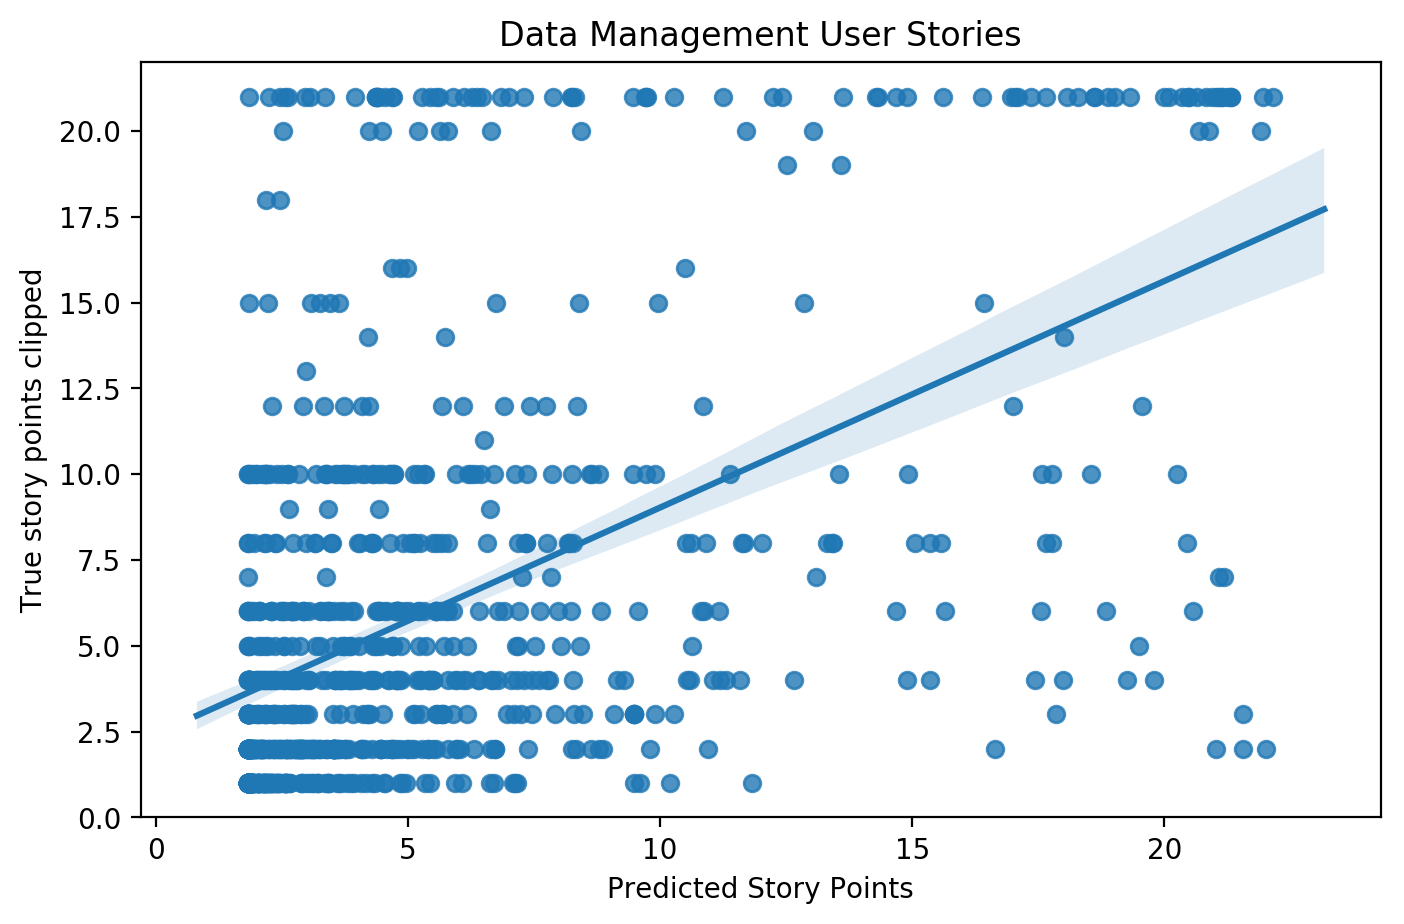

In [404]:
figura = plt.figure(figsize=(8, 5), dpi=200)
plt.xlabel("Predicted Story Points")
plt.ylabel("True story points clipped")
plt.title("%s User Stories" % project_name[project])
sns.regplot(val_pred.ravel(), y_val.clip(1, 21).ravel())
plt.plot()
figura.savefig("results/figures/"+project+"-vs-true.pdf", bbox_inches='tight')

In [390]:
initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights(), 0)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, min_delta=0)
save_best = keras.callbacks.ModelCheckpoint(model_data_path % project, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
log_csv = keras.callbacks.CSVLogger(log_data_path % project)
hist_train = mod_train.fit(x_train, np.clip(y_train, 1, story_points_clip[project]), epochs=40, validation_data=(x_val, np.clip(y_val, 1, story_points_clip[project])), callbacks=[save_best, log_csv, early_stopping])
save_to_pickle(hist_train.history, hist_data_path % project)

Train on 700 samples, validate on 233 samples
Epoch 1/40
700/700 [==============================] - 6s 9ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 2/40
700/700 [==============================] - 6s 9ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 3/40
700/700 [==============================] - 6s 8ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 4/40
700/700 [==============================] - 6s 8ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 5/40
700/700 [==============================] - 6s 8ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 6/40
700/700 [==============================] - 6s 9ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 7/40
700/700 [==============================] - 6s 9ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 8/40
700/700 [==============================] - 6s 8ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 9/40
700/700 [==============================] - 6s 8ms/step - loss: 1.8371 - val_loss: 1.9356
Epoch 10/40
700/700 [==============================] -

<IPython.core.display.Javascript object>

In [380]:
project

'talendesb'

In [291]:
np.mean(np.abs(np.median(y_train)-y_train))

12.828571

In [292]:
np.abs(np.median(y_train)-y_train)

array([[92.],
       [92.],
       [12.],
       [12.],
       [ 5.],
       [92.],
       [92.],
       [ 4.],
       [ 0.],
       [32.],
       [12.],
       [32.],
       [92.],
       [92.],
       [ 6.],
       [ 5.],
       [32.],
       [32.],
       [32.],
       [12.],
       [ 5.],
       [32.],
       [ 0.],
       [12.],
       [12.],
       [ 5.],
       [ 5.],
       [ 5.],
       [12.],
       [ 3.],
       [92.],
       [ 0.],
       [ 0.],
       [ 6.],
       [12.],
       [ 3.],
       [ 0.],
       [92.],
       [12.],
       [32.],
       [ 5.],
       [ 4.],
       [12.],
       [ 5.],
       [12.],
       [12.],
       [12.],
       [ 0.],
       [ 5.],
       [32.],
       [32.],
       [ 3.],
       [ 5.],
       [92.],
       [ 0.],
       [ 5.],
       [ 5.],
       [92.],
       [92.],
       [12.],
       [ 0.],
       [ 0.],
       [ 6.],
       [ 6.],
       [ 5.],
       [ 5.],
       [ 5.],
       [92.],
       [ 3.],
       [ 0.],
       [ 5.],
      

In [382]:
mod_view = keras.models.Model(inputs=mod_train.inputs, outputs=[l.output for l in mod_train.layers[-8:-1]])

In [383]:
a = mod_view.predict(x_val)

In [385]:
a

[array([[-0.14467707,  0.23685238,  0.20907314, ..., -0.32219583,
          0.29074582, -0.17047694],
        [-0.33806506,  0.12037657, -0.00831316, ...,  0.10898098,
          0.2249496 , -0.03225243],
        [-0.17766905,  0.22341484,  0.34362593, ..., -0.13149364,
          0.42171258, -0.41371283],
        ...,
        [-0.3271362 ,  0.3220314 ,  0.0252365 , ..., -0.29262614,
         -0.04274324, -0.03021637],
        [-0.08314551, -0.33722562,  0.03482156, ...,  0.05930808,
          0.24999262, -0.23202918],
        [-0.0263191 ,  0.22709176,  0.23832202, ..., -0.3469512 ,
          0.22751883, -0.01288723]], dtype=float32),
 array([[-0.14467707,  0.23685238,  0.20907314, ..., -0.32219583,
          0.29074582, -0.17047694],
        [-0.33806506,  0.12037657, -0.00831316, ...,  0.10898098,
          0.2249496 , -0.03225243],
        [-0.17766905,  0.22341484,  0.34362593, ..., -0.13149364,
          0.42171258, -0.41371283],
        ...,
        [-0.3271362 ,  0.3220314 ,  0.0

In [365]:
mod_train.layers[-8:-1]

In [288]:
np.median(y_train)

8.0

In [289]:
np.sum(y_train)

12072.0

In [343]:
mod_train.get_weights()

[array([[ 0.01158899, -0.03165118, -0.01472145, ..., -0.03753223,
         -0.0183831 ,  0.03914304],
        [ 0.16900912,  0.00520417,  0.30961126, ..., -0.29867357,
         -0.09086336, -0.27886   ],
        [ 0.12684323, -0.00819551, -0.47751638, ..., -0.5539134 ,
          0.09783418,  1.1602142 ],
        ...,
        [-0.16045798,  2.2415278 , -1.594621  , ..., -2.0644898 ,
          0.52367055, -0.5228918 ],
        [-1.0635546 , -2.665689  ,  0.51050216, ..., -3.9606671 ,
          1.3807639 , -0.524296  ],
        [ 1.8221983 , -0.5494846 ,  0.29670298, ..., -1.0804262 ,
          1.2936594 , -0.944587  ]], dtype=float32),
 array([[ 6.4449599e-03,  8.2292818e-02,  7.5516000e-02, ...,
          1.0827334e-01,  6.0835830e-03,  6.7105897e-02],
        [-8.7636620e-02,  1.2118631e-01,  4.1706558e-02, ...,
         -1.0539040e-01, -4.7594115e-02, -3.8659345e-02],
        [ 6.0473181e-02, -2.4698034e-02,  4.8264809e-02, ...,
         -5.0183110e-02,  5.0813414e-02, -6.6307381e-02]

In [338]:
a = mod_train.layers[-2]

In [339]:
b = a.get_output_at?

In [ ]:
b = a.get_output_at

In [337]:
mod_train.layers[-2].get_

Elemwise{mul,no_inplace}.0

In [342]:
x_val

array([[ 469,   60,   23, ...,    0,    0,    0],
       [ 405,   19,   67, ...,    0,    0,    0],
       [ 839,  663,  276, ...,    0,    0,    0],
       ...,
       [   1,   15,    1, ...,    0,    0,    0],
       [  67,    1, 1010, ...,    0,    0,    0],
       [1310, 1260,   23, ...,    0,    0,    0]], dtype=int16)

In [ ]:
b = a.call

In [243]:
a = [1, 2,3]

In [254]:
a.append(43322)

In [251]:
a.insert(0, 443)

In [255]:
a.

[443, 1, 2, 0, 43322]

In [229]:
rerodar = ['mesos', 'aptanastudio', 'titanium', 'duracloud', 'jirasoftware', 'moodle',
           'mulestudio','springxd','talendesb']
perto = ['mule','talenddataquality']

In [391]:
rerodar

['mesos',
 'appceleratorstudio',
 'aptanastudio',
 'titanium',
 'duracloud',
 'jirasoftware',
 'moodle',
 'mule',
 'mulestudio',
 'springxd',
 'talendesb']

mesos


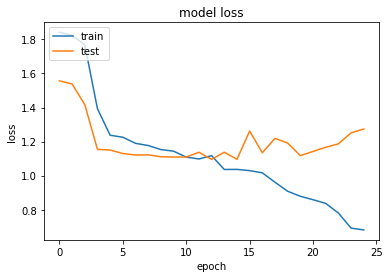

usergrid


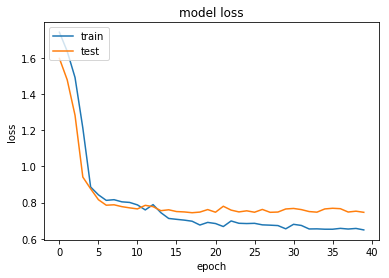

appceleratorstudio


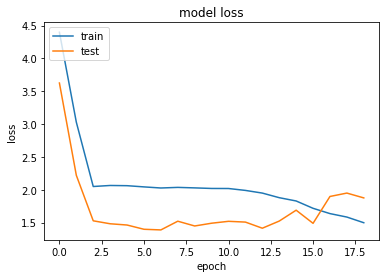

aptanastudio


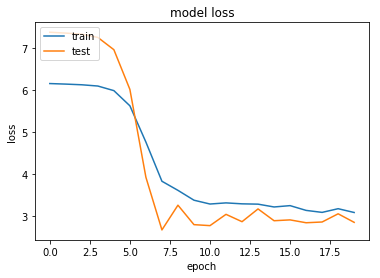

titanium


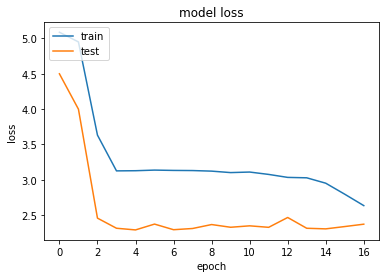

duracloud


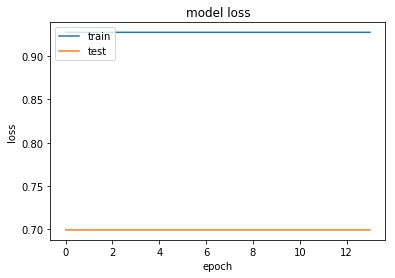

bamboo


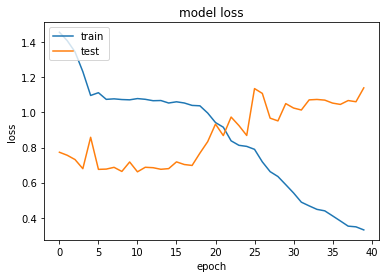

clover


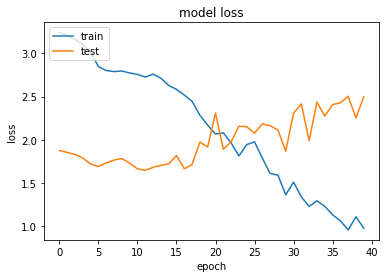

jirasoftware


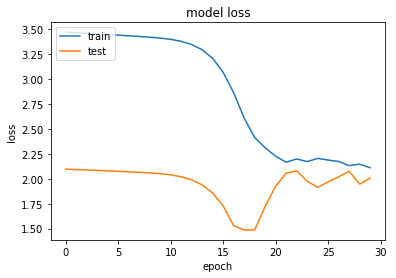

moodle


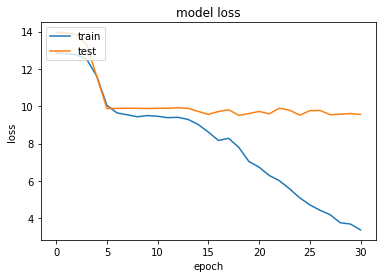

datamanagement


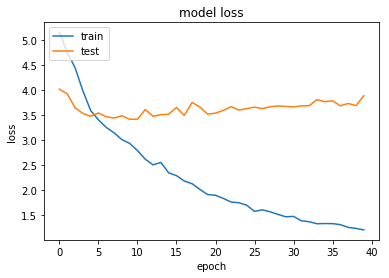

mule


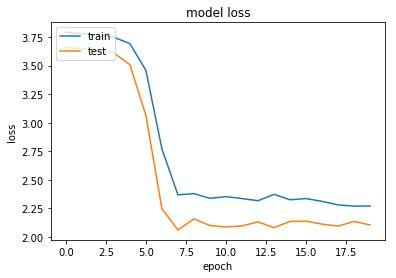

mulestudio


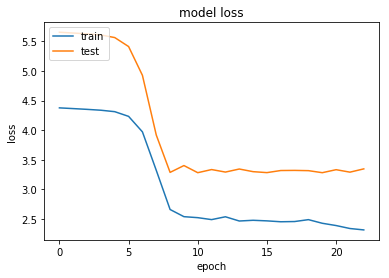

springxd


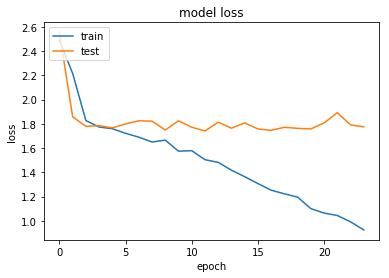

talenddataquality


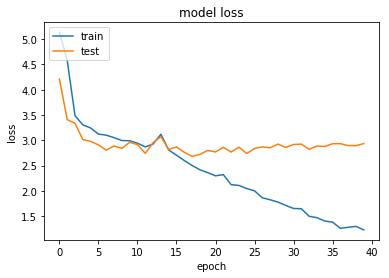

talendesb


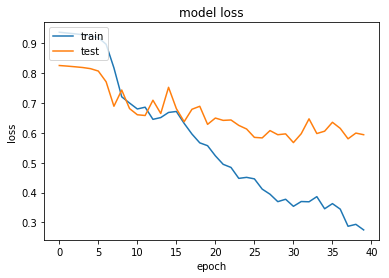

['mesos',
 'appceleratorstudio',
 'aptanastudio',
 'titanium',
 'duracloud',
 'jirasoftware',
 'moodle',
 'mulestudio',
 'springxd']

In [393]:
rerodar = []
for project in project_repos.keys():
    print(project)
    h = load_pickle(hist_data_path % project)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    if min(h['val_loss']) / deepse_baseline[project] > 0.95:
        rerodar.append(project)
rerodar

In [27]:
class EstimativaConstrastivaRuidosa(keras.layers.Layer):
    def __init__(self, init='glorot_uniform', comprimento=10,
                 dimensao_entrada=None, vocabulario=None, ruidos = 25, distribuicao_ruidos=[0.5, 0.5], semente=19, **kwargs):
        self.init = init
        self.comprimento = comprimento
        self.vocabulario = vocabulario
        self.ruidos = ruidos
        self.distribuicao_ruidos = theano.shared(np.array(distribuicao_ruidos).astype(theano.config.floatX)) #IMP
        self.gerador_aleatorio = theano.tensor.shared_randomstreams.RandomStreams(seed=semente) #IMP
        self.dimensao_entrada = dimensao_entrada
        kwargs['input_shape'] = (self.dimensao_entrada, )
        super(EstimativaConstrastivaRuidosa, self).__init__(**kwargs)

    def build(self, dims_entrada):
        self.W = self.add_weight(name='{}_W'.format(self.name), shape=(self.vocabulario, self.dimensao_entrada), initializer=self.init, trainable=True)
        self.b = self.add_weight(name='{}_b'.format(self.name), shape=(self.vocabulario, )                     , initializer=self.init, trainable=True)
        super(EstimativaConstrastivaRuidosa, self).build(dims_entrada)

    def compute_output_shape(self, dims_entrada):
        return (None, self.comprimento, self.ruidos + 1)
    
    def compute_mask(self, input, mask=None):
        return mask[0]

    def call(self, inputs, mask=None):
        contexto = inputs[0] #shape: amostras * passos * dim
        proxima_palavra = inputs[1] #shape: amostras * passos

        amostras, passos = proxima_palavra.shape
        dim_saida = self.ruidos + 1

        noise_w = self.gerador_aleatorio.choice(size=(amostras, passos, self.ruidos), a=self.distribuicao_ruidos.shape[0], p=self.distribuicao_ruidos)
        proxima_palavra = proxima_palavra.flatten().reshape([amostras, passos, 1])
        proxima_palavra = theano.tensor.concatenate([proxima_palavra, noise_w], axis=-1) #IMP shape: amostras * passos * dim_saida

        W_ = self.W[proxima_palavra.flatten()].flatten().reshape([amostras, passos, dim_saida, self.dimensao_entrada])
        b_ = self.b[proxima_palavra.flatten()].reshape([amostras, passos, dim_saida])

        s_theta = (contexto[:, :, None, :] * W_).sum(axis=-1) + b_ # dims: amostras * passos * dim_saida
        noiseP = self.distribuicao_ruidos[proxima_palavra.flatten()].reshape([amostras, passos, dim_saida])
        noise_score = keras.backend.log(self.ruidos * noiseP) #log(k * distribuicao_ruidos(w))

        return keras.activations.sigmoid(s_theta - noise_score) # dims: amostras, passos, dim_saida

def custo_estimativa_contrastiva(real, estimado):
    custo = K.binary_crossentropy(estimado, real[:, :, 1:])
    custo = custo.sum(axis=-1)
    custo *= real[:, :, 0]
    return K.sum(custo) / K.sum(real[:, :, 0])

def separar_xy_mascara(sequencias, vocabulario=5000, comprimento_maximo=100):
    novas_sequencias = [[palavra if palavra < vocabulario else 0 for p in s] for s in sequencias]

    comprimentos = [min(comprimento_maximo, len(s)-1) for s in sequencias]
    comprimento_maximo = max(comprimentos)
    amostras = numpy.count_nonzero(comprimentos)

    x = numpy.zeros((amostras, comprimento_maximo)).astype('int32')
    y = numpy.zeros((amostras, comprimento_maximo)).astype('int32')
    mascara = numpy.zeros((amostras, comprimento_maximo)).astype('int32')

    idx = 0
    for i, s in enumerate(sequencias):
        l = comprimentos[i]
        if l < 1: continue
        mask[idx, :l] = 1
        x[idx, :l] = s[:l]
        y[idx, :l] = s[1 : l+1]
        x[idx] += mask[idx]
        y[idx] += mask[idx]
        idx += 1

    return x, y, mascara

def calcular_distancias(sequencias, indice_maximo):
    Pn = np.zeros((maxword,))
    for s in sequencias:
        for w in s:
            if w >= indice_maximo: Pn[0] += 1
            else: Pn[w] += 1
    Pn = 1.0 * Pn / sum(Pn)
    return Pn

In [23]:
def modelo_pretreinamento(vocabulario, dim_vetorial, comprimento, ruidos, distribuicao_ruidos):
    entrada_atual = Input(shape=(comprimento,), dtype='int32', name='entrada_atual')
    proxima_entrada = Input(shape=(comprimento,), dtype='int32', name='proxima_entrada')
    vetorizado = Embedding(output_dim=dim_vetorial, input_dim=vocabulario, input_length=comprimento, mask_zero=True)(entrada_atual)
    contexto_recorrente = LSTM(dim_vetorial, input_shape=(None, dim_vetorial), return_sequences=True)(vetorizado)
    estimativa = EstimativaConstrastivaRuidosa(dimensao_entrada=dim_vetorial, comprimento=comprimento, vocabulario=vocabulario,
                ruidos=ruidos, distribuicao_ruidos=distribuicao_ruidos)([contexto_recorrente, proxima_entrada])
    return Model(inputs=[entrada_atual, proxima_entrada], outputs=estimativa)

In [21]:
ruidos = 100
comprimento_maximo = 100
dim_vetorial = 200
vocabulario_maximo = 5000

x_treino, y_treino, mascara_treino = separar_xy_mascara(treino, vocabulario_maximo, comprimento_maximo)

vocabulario_maximo += 1
amostras, comprimento = x_treino.shape
Pn = calcular_distancias(treino, vocabulario_maximo)
masc_treino = numpy.zeros((amostras, comprimento, ruidos + 2), dtype='int64')
masc_treino[:, :, 0] = mascara_treino
masc_treino[:, :, 1] = 1

In [30]:
modelo_pretreino = modelo_pretreinamento(vocabulario_maximo, dim_vetorial, comprimento, ruidos, Pn)

In [31]:
modelo_pretreino.compile(optimizer='adam', loss=custo_estimativa_contrastiva)

In [32]:
historico_pretreino = model.fit([x_treino, y_treino], masc_treino, batch_size=64, epochs=20)

Epoch 1/20
  320/10970 [..............................] - ETA: 6:16 - loss: 16.7152

KeyboardInterrupt: 

In [2]:
import numpy
import theano
from theano import config
import theano.tensor as tensor
import theano.tensor.shared_randomstreams as RS

import keras
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.engine.topology import Layer
from keras.callbacks import *

SEED = 1234

class NCEContext(Layer):
    def __init__(self, init='glorot_uniform', activation='linear',
                 weights=None, input_dim=None, context_dim=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=False, **kwargs):
        self.init = initializers.get(init)
        self.activation = activations.get(activation)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights

        self.input_dim = input_dim
        self.context_dim = context_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        super(NCEContext, self).__init__(**kwargs)

    def build(self, input_shape): #input shape: nsamples * n_context * dim
        self.C = self.init((self.context_dim, self.input_dim),
                           name='{}_C'.format(self.name))
        self.trainable_weights = [self.C]

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.input_dim)

    def call(self, x, mask=None):
        #x shape: nsamples * n_context * dim
        #out shape: nsamples * dim
        out = self.C[None, :, :] * x
        out = out.sum(axis=-2)
        return out

    def get_config(self):
        config = {'init': self.init.__name__,
                  'activation': self.activation.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'b_regularizer': self.b_regularizer.get_config() if self.b_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'b_constraint': self.b_constraint.get_config() if self.b_constraint else None,
                  'bias': self.bias,
                  'input_dim': self.input_dim,
                  'context_dim': self.context_dim}
        base_config = super(NCEContext, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class NCE(Layer):
    def __init__(self, init='glorot_uniform', activation='linear',
                 input_dim=None, vocab_size=None, n_noise = 25, Pn=[0.5, 0.5],
                 weights=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.init = init #initializers.get(init)
        self.activation = activations.get(activation)
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.n_noise = n_noise
        self.Pn = theano.shared(numpy.array(Pn).astype(config.floatX))
        self.rng = RS.RandomStreams(seed=SEED)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        super(NCE, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='{}_W'.format(self.name),
            shape=(self.vocab_size, self.input_dim),
            initializer=self.init,
        )
        #self.init((self.vocab_size, self.input_dim), name='{}_W'.format(self.name))

        if self.bias:
            self.b = self.add_weight(
                name='{}_b'.format(self.name),
                shape=(self.vocab_size,),
                initializer=self.init,
            )
            #self.init((self.vocab_size,), name='{}_b'.format(self.name))
            self.trainable_weights = [self.W, self.b]
        else:
            self.trainable_weights = [self.W]

        self.regularizers = []
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)

        if self.bias and self.b_regularizer:
            self.b_regularizer.set_param(self.b)
            self.regularizers.append(self.b_regularizer)

        if self.activity_regularizer:
            self.activity_regularizer.set_layer(self)
            self.regularizers.append(self.activity_regularizer)

        self.constraints = {}
        if self.W_constraint:
            self.constraints[self.W] = self.W_constraint

        if self.bias and self.b_constraint:
            self.constraints[self.b] = self.b_constraint

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        super(NCE, self).build(input_shape)

    def get_output_shape_for(self, input_shape):
        return (None, self.n_noise + 1)

    def call(self, inputs, mask=None):
        context = inputs[0] #shape: n_samples * dim
        next_w = inputs[1] #shape: n_samles * 1

        n_samples = next_w.shape[0]
        n_next = self.n_noise + 1

        #generate n_noise samples from noise distribution Pn.
        noise_w = self.rng.choice(size=(n_samples, self.n_noise), a=self.Pn.shape[0], p=self.Pn)
        next_w = tensor.concatenate([next_w, noise_w], axis=-1)

        W_ = self.W[next_w.flatten()].flatten().reshape([n_samples, n_next, self.input_dim])
        b_ = self.b[next_w.flatten()].reshape([n_samples, n_next])

        # compute s_theta(w): scores of words under the model
        s_theta = (context[:, None, :] * W_).sum(axis=-1) + b_
        # compute the scores of words under the noise distribution: log(k * Pn(w))
        noiseP = self.Pn[next_w.flatten()].reshape([n_samples, n_next])
        noise_score = K.log(self.n_noise * noiseP)

        # the difference in the scores of words under the model and the noise distribution
        # shape: n_samples * n_next
        out = s_theta - noise_score

        return activations.sigmoid(out)

    def get_config(self):
        config = {'init': self.init,
                  'activation': self.activation.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'b_regularizer': self.b_regularizer.get_config() if self.b_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'b_constraint': self.b_constraint.get_config() if self.b_constraint else None,
                  'bias': self.bias,
                  'input_dim': self.input_dim,
                  'vocab_size': self.vocab_size,
                  'n_noise': self.n_noise
                  }
        base_config = super(NCE, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class NCE_seq(NCE):
    def __init__(self, input_len=10, **kwargs):
        self.input_len = input_len
        super(NCE_seq, self).__init__(**kwargs)

    def compute_mask(self, input, mask=None):
        return mask[0]

    def get_output_shape_for(self, input_shape):
        return (None, self.input_len, self.n_noise + 1)

    def call(self, inputs, mask=None):
        context = inputs[0] #shape: n_samples * n_steps * dim
        next_w = inputs[1] #shape: n_samles * n_steps

        n_samples, n_steps = next_w.shape
        n_next = self.n_noise + 1

        #generate n_noise samples from noise distribution Pn.
        noise_w = self.rng.choice(size=(n_samples, n_steps, self.n_noise), a=self.Pn.shape[0], p=self.Pn)
        next_w = next_w.flatten().reshape([n_samples, n_steps, 1])
        next_w = tensor.concatenate([next_w, noise_w], axis=-1) # shape: n_samples * n_steps * n_next

        W_ = self.W[next_w.flatten()].flatten().reshape([n_samples, n_steps, n_next, self.input_dim])
        b_ = self.b[next_w.flatten()].reshape([n_samples, n_steps, n_next])

        # compute s_theta(w): scores of words under the model
        # s_theta shape: n_samples * n_steps * n_next
        s_theta = (context[:, :, None, :] * W_).sum(axis=-1) + b_
        # compute the scores of words under the noise distribution: log(k * Pn(w))
        noiseP = self.Pn[next_w.flatten()].reshape([n_samples, n_steps, n_next])
        noise_score = K.log(self.n_noise * noiseP)

        # the difference in the scores of words under the model and the noise distribution
        # output shape: n_samples, n_steps, n_next
        out = s_theta - noise_score

        return activations.sigmoid(out)

class NCETest(NCE):
    def get_output_shape_for(self, input_shape):
        return (None, 1)

    def call(self, inputs, mask=None):
        context = inputs[0] # shape: n_samples * dim
        next_w = inputs[1] # shape: n_samples * 1
        n_samples = next_w.shape[0]

        out = K.dot(context, K.transpose(self.W)) + self.b
        out = activations.softmax(out)
        next_w = next_w.flatten()
        return out[tensor.arange(n_samples), next_w]

class NCETest_seq(NCETest):
    def __init__(self, input_len=10, **kwargs):
        self.input_len = input_len
        super(NCETest_seq, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        return (None, self.input_len)

    def compute_mask(self, input, mask=None):
        return mask[0]

    def call(self, inputs, mask=None):
        context = inputs[0] # shape: n_samples * n_steps * dim
        next_w = inputs[1] # shape: n_samples * n_steps
        n_samples, n_steps = next_w.shape
        vocab_size = self.W.shape[0]

        out = K.dot(context, K.transpose(self.W)) + self.b
        out = activations.softmax(out)
        out = out.flatten().reshape([n_samples*n_steps, vocab_size])
        next_w = next_w.flatten()

        prob = out[tensor.arange(n_samples*n_steps), next_w]
        prob = prob.reshape([n_samples, n_steps])
        return prob

class NCETestCallback(Callback):
    def __init__(self, data, testModel, fResult, fParams, patient=3):
        self.testModel = testModel
        self.fResult = fResult
        self.fParams = fParams
        self.patient = patient
        self.num_patient = patient
        self.best_epoch = 0
        self.best_loss = 100000.0

        self.do_test = False
        if len(data) == 2 or len(data) == 4:
            self.isSeq = 0
            self.valid_x = data[0]
            self.valid_y = data[1]
            self.valid_mask = data[0]

            if len(data) == 4:
                self.do_test = True
                self.test_x = data[2]
                self.test_y = data[3]
                self.test_mask = data[2]

        else:
            self.isSeq = 1
            self.valid_x, self.valid_y, self.valid_mask = data[0], data[1], data[2]
            if len(data) == 6:
                self.do_test = True
                self.test_x, self.test_y, self.test_mask = data[3], data[4], data[5]

        flog = open(fResult, 'w')
        flog.write('epoch\ttr_loss\tv_ppl\n')
        flog.close()
        super(NCETestCallback, self).__init__()

    def _compute_result(self, x, y, mask):
        y_pred = self.testModel.predict([x, y], batch_size=30)
        if self.isSeq:
            per = perplexity(mask, y_pred, 1)
        else:
            per = perplexity(mask, y_pred, 0)
        return per

    def on_epoch_end(self, epoch, logs={}):
        weights = self.model.get_weights()
        self.testModel.set_weights(weights)

        v_per = self._compute_result(self.valid_x, self.valid_y, self.valid_mask)
        if self.do_test:
            t_per = self._compute_result(self.test_x, self.test_y, self.test_mask)

        if self.best_loss < v_per:
            self.patient -= 1

            if self.patient == 0:
                lr = self.model.optimizer.lr / 2.0
                self.model.optimizer.lr = lr
                self.patient = self.num_patient
        else:
            self.patient = self.num_patient
            self.best_loss = v_per
            self.best_epoch = epoch
            self.model.save_weights(self.fParams, overwrite=True)

        print ('validation perplexity: %.4f' % v_per)

        train_loss = 0
        if 'loss' in logs:
            train_loss = logs['loss']

        f = open(self.fResult, 'a')
        f.write('%d\t%.4f\t%.4f' % (epoch, train_loss, v_per))
        if self.do_test:
            f.write('\t%.4f' % t_per)
        f.write('\tBest at epoch %d' % self.best_epoch)
        f.write('\n')
        f.close()

def NCE_seq_loss(y_true, y_pred):
    # y_true[:, :, 0]: masking matrix
    # y_true[:, :, 1] = 1: words from data
    # y_true[:, :, 2:] = 0: words from noise distribution
    # y_pred: probability of the word to be from data - shape: n_samples * n_steps * (n_noise + 1)

    loss = K.binary_crossentropy(y_pred, y_true[:, :, 1:])
    loss = loss.sum(axis=-1)
    loss *= y_true[:, :, 0] # masking matrix
    return K.sum(loss) / K.sum(y_true[:, :, 0])

def NCE_seq_loss_test(y_true, y_pred):
    # y_pred: n_samples * n_steps - probability of next word to be the corresponding word in y_true
    # y_true: masking matrix

    loss = -tensor.log(y_pred)
    loss *= y_true
    loss = K.sum(loss) / K.sum(y_true)
    return K.exp(loss)

def NCE_loss(y_true, y_pred): #n_samples * n_next
    loss = K.binary_crossentropy(y_pred, y_true)
    loss = K.mean(loss.sum(axis=-1))
    return loss

def NCE_loss_test(y_true, y_pred): #(n_samples,)
    loss = - tensor.log(y_pred)
    loss = K.mean(loss)
    loss = K.exp(loss)

    return loss

def perplexity(y_true, y_pred, isSeq = 0): #(n_samples,) or (n_samples, n_steps)
    eps = 1e-4
    loss = - numpy.log(y_pred + eps)

    if isSeq: # sequence
        loss *= y_true
        loss = numpy.sum(loss) / numpy.sum(y_true)
    else:
        loss = numpy.mean(loss)

    loss = numpy.exp(loss)
    return loss


In [3]:
import numpy

def calc_dist(seqs, maxword):
    Pn = numpy.zeros((maxword,))

    for s in seqs:
        for w in s:
            if w >= maxword: Pn[0] += 1
            else: Pn[w] += 1

    Pn = 1.0 * Pn / sum(Pn)

    return Pn

def generate_noise(n_samples, n_noise, Pn):
    noise = numpy.zeros((n_samples, n_noise), dtype='int64')
    for i in range(n_samples):
        noise[i] = numpy.random.choice(len(Pn), n_noise, p=Pn)

    return noise

In [8]:
import gzip
import pickle

def load(path):
    f = gzip.open(path, 'rb')
    train, valid, test = pickle.load(f)
    #print path, len(train[0]), len(valid[0])

    return train, valid, test

def prepare_lm(seqs, vocab_size=10000, max_len=100):
    new_seqs = []
    for i, s in enumerate(seqs):
        new_s = [w if w < vocab_size else 0 for w in s]
        new_seqs.append(new_s)
    seqs = new_seqs

    lengths = [min(max_len, len(s)-1) for s in seqs]
    maxlen = max(lengths)
    n_samples = numpy.count_nonzero(lengths)

    x = numpy.zeros((n_samples, maxlen)).astype('int64')
    y = numpy.zeros((n_samples, maxlen)).astype('int64')
    mask = numpy.zeros((n_samples, maxlen)).astype('int64')

    idx = 0
    for i, s in enumerate(seqs):
        l = lengths[i]
        if l < 1: continue
        mask[idx, :l] = 1
        x[idx, :l] = s[:l]
        y[idx, :l] = s[1 : l+1]
        x[idx] += mask[idx]
        y[idx] += mask[idx]
        idx += 1

    return x, y, mask


In [5]:
from keras.layers import *
from keras.models import Model
from keras.constraints import *
from keras.regularizers import *
import numpy

dataset = 'dados/pretreino/moodle_pretrain.pkl.gz'
emb_dim = 200
max_len = 100

n_noise = 100
print ('Loading data...')
train, valid, test = load(dataset)
valid = valid[-5000:]
vocab_size = 5000

print ('vocab: ', vocab_size)

train_x, train_y, train_mask = prepare_lm(train, vocab_size, max_len)
valid_x, valid_y, valid_mask = prepare_lm(valid, vocab_size, max_len)

print ('Data size: Train: %d, valid: %d' % (len(train_x), len(valid_x)))

vocab_size += 1
n_samples, inp_len = train_x.shape
Pn = calc_dist(train, vocab_size)
labels = numpy.zeros((n_samples, inp_len, n_noise + 2), dtype='int64')
labels[:, :, 0] = train_mask
labels[:, :, 1] = 1

main_inp = Input(shape=(inp_len,), dtype='int64', name='main_inp')
next_inp = Input(shape=(inp_len,), dtype='int64', name='next_inp')
emb_vec = Embedding(output_dim=emb_dim, input_dim=vocab_size, input_length=inp_len,
                    #dropout=0.2,
                    mask_zero=True)(main_inp)
GRU_context = LSTM(emb_dim, input_shape=(None, emb_dim), return_sequences=True)(emb_vec)
nce_out = NCE_seq(input_dim=emb_dim, input_len=inp_len, vocab_size=vocab_size, n_noise=n_noise, Pn=Pn,
              )([GRU_context, next_inp])
model = Model(inputs=[main_inp, next_inp], outputs=[nce_out])
optimizer = RMSprop(lr=0.02, rho=0.99, epsilon=1e-7) #optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss=NCE_seq_loss)
print(model.summary())
his = model.fit([train_x, train_y], labels,
          batch_size=50, epochs=20)

Loading data...
vocab:  5000
Data size: Train: 67794, valid: 4869


/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_inp (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     1000200     main_inp[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100, 200)     320800      embedding_1[0][0]                
__________________________________________________________________________________________________
next_inp (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
nce_seq_1 

KeyboardInterrupt: 

In [7]:
Pn.shape

(5001,)

## Treinamento

In [ ]:
def modelo_treinamento(n_classes, vocab_size, inp_len, emb_dim,
                 seq_model='lstm', nnet_model='highway', pool_mode='mean',
                 dropout_inp=False, dropout_hid=True, emb_weight=None, hidden_layer=None):
    if emb_weight is not None:
        emb_weight = [emb_weight[:vocab_size]]
    seq_dict = {'lstm': LSTM, 'gru': GRU, 'rnn': SimpleRNN}
    nnet_dict = {'highway': create_highway, 'dense': create_dense}
    if n_classes == -1:
        top_act = 'linear'
    elif n_classes == 1:
        top_act = 'sigmoid'
    else:
        top_act = 'softmax'

    title_inp = Input(shape=(inp_len,), dtype='int64', name='title_inp')
    descr_inp = Input(shape=(inp_len,), dtype='int64', name='descr_inp')

    title_mask = Input(shape=(inp_len,), dtype='float32', name='title_mask')
    descr_mask = Input(shape=(inp_len,), dtype='float32', name='descr_mask')

    if dropout_inp:
        drop_rate = 0.2
    else:
        drop_rate = 0.0

    embedding = Embedding(output_dim=emb_dim, input_dim=vocab_size, input_length=inp_len,
                          mask_zero=True, weights=emb_weight,
                          dropout=drop_rate)
    seq_layer = seq_dict[seq_model](input_dim=emb_dim, output_dim=emb_dim,
                                    return_sequences=True, dropout_U=drop_rate, dropout_W=drop_rate)

    title_emb = embedding(title_inp)
    descr_emb = embedding(descr_inp)

    title_hid = seq_layer(title_emb)
    descr_hid = seq_layer(descr_emb)

    pooled_title = PoolingSeq(mode=pool_mode)([title_hid, title_mask])
    pooled_descr = PoolingSeq(mode=pool_mode)([descr_hid, descr_mask])

    hidd = Average()([pooled_title, pooled_descr])
    if dropout_hid:
        hidd = Dropout(0.5)(hidd)

    hidd = nnet_dict[nnet_model](hidd, emb_dim, hidden_layer)
    hidd = Dropout(0.5)(hidd)
    top_hidd = Dense(output_dim=abs(n_classes), activation=top_act)(hidd)

    model = Model(input=[title_inp, title_mask, descr_inp, descr_mask], output=top_hidd)

    return model

## Avaliação

In [2]:
'''
#This example demonstrates the use of fasttext for text classification
Based on Joulin et al's paper:
[Bags of Tricks for Efficient Text Classification
](https://arxiv.org/abs/1607.01759)
Results on IMDB datasets with uni and bi-gram embeddings:
Embedding|Accuracy, 5 epochs|Speed (s/epoch)|Hardware
:--------|-----------------:|----:|:-------
Uni-gram |            0.8813|    8|i7 CPU
Bi-gram  |            0.9056|    2|GTx 980M GPU
'''

from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Adding 2-gram features
Average train sequence length: 476
Average test sequence length: 428
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 45s 2ms/step - loss: 0.5862 - acc: 0.7874 - val_loss: 0.4372 - val_acc: 0.8548
Epoch 2/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.2877 - acc: 0.9276 - val_loss: 0.3030 - val_acc: 0.8904
Epoch 3/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.1432 - acc: 0.9696 - val_loss: 0.2628 - val_acc: 0.8998
Epoch 4/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.0775 - acc: 0.9871 - val_loss: 0.2441 - val_acc: 0.9030
Epoch 5/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.0437 

In [23]:
imdb.np

<module 'numpy' from '/usr/lib64/python3.6/site-packages/numpy/__init__.py'>

In [14]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant


BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove_en')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
validation_data=(x_val, y_val))

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.
Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Training model.
Train on 15998 samples, validate on 3999 samples
Epoch 1/10
15998/15998 [==============================] - 5s 340us/step - loss: 2.4037 - acc: 0.2187 - val_loss: 1.8067 - val_acc: 0.3768
Epoch 2/10
15998/15998 [==============================] - 4s 276us/step - loss: 1.5519 - acc: 0.4621 - val_loss: 1.4603 - val_acc: 0.5064
Epoch 3/10
15998/15998 [==============================] - 4s 276us/step - loss: 1.1902 - acc: 0.5953 - val_loss: 1.1682 - val_acc: 0.5969
Epoch 4/10
15998/15998 [==============================] - 4s 276us/step - loss: 0.9690 - acc: 0.6748 - val_loss: 1.0070 - val_acc: 0.6624
Epoch 5/10
15998/15998 [==============================] - 4s 276us/step - loss: 0.8137 - acc: 0.7250 - val_loss: 0.9541 - val_acc: 0.6784
Epoch 6/10
15998/15998 [=

In [30]:
'''Trains and evaluate a simple MLP
on the Reuters newswire topic classification task.
'''
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

max_words = 1000
batch_size = 64
epochs = 50

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Loading data...
8982 train sequences
2246 test sequences
46 classes
Vectorizing sequence data...
x_train shape: (8982, 1000)
x_test shape: (2246, 1000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)
Building model...
Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 0s 24us/step - loss: 1.5670 - acc: 0.6538 - val_loss: 1.1814 - val_acc: 0.7442
Epoch 2/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.8898 - acc: 0.7982 - val_loss: 0.9999 - val_acc: 0.7798
Epoch 3/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.6416 - acc: 0.8458 - val_loss: 0.8985 - val_acc: 0.7875
Epoch 4/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.4929 - acc: 0.8820 - val_loss: 0.8817 - val_acc: 0.8031
Epoch 5/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.3945 - acc: 0.9042 - val_loss

In [31]:
# -*- coding: utf-8 -*-
'''
# An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits reversed:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits reversed:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits reversed:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits reversed:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''  # noqa

from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
print(guess)

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
Train on 45000 samples, validat

45000/45000 [==============================] - 5s 101us/step - loss: 0.2601 - acc: 0.9329 - val_loss: 0.2259 - val_acc: 0.9476
Q 31+209  T 240  ☑ Q 800+952 T 1752 ☒ Q 795+24  T 819  ☑ Q 674+668 T 1342 ☑ Q 63+85   T 148  ☑ Q 834+409 T 1243 ☑ Q 292+700 T 992  ☑ Q 8+629   T 637  ☑ Q 764+282 T 1046 ☑ Q 85+187  T 272  ☑ 
--------------------------------------------------
Iteration 16
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.1878 - acc: 0.9603 - val_loss: 0.1780 - val_acc: 0.9577
Q 773+511 T 1284 ☑ Q 336+527 T 863  ☑ Q 755+30  T 785  ☑ Q 32+724  T 756  ☑ Q 773+4   T 777  ☑ Q 2+42    T 44   ☑ Q 998+21  T 1019 ☑ Q 698+676 T 1374 ☒ Q 238+80  T 318  ☑ Q 73+60   T 133  ☑ 
--------------------------------------------------
Iteration 17
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.1460 - acc: 0.9711 - val_loss: 0.1520 - val_acc

45000/45000 [==============================] - 5s 101us/step - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0055 - val_acc: 0.9991
Q 760+714 T 1474 ☑ Q 321+21  T 342  ☑ Q 946+14  T 960  ☑ Q 1+829   T 830  ☑ Q 803+630 T 1433 ☑ Q 11+872  T 883  ☑ Q 77+796  T 873  ☑ Q 450+559 T 1009 ☑ Q 779+416 T 1195 ☑ Q 95+984  T 1079 ☑ 
--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0073 - val_acc: 0.9981
Q 228+10  T 238  ☑ Q 892+845 T 1737 ☑ Q 359+91  T 450  ☑ Q 27+105  T 132  ☑ Q 53+222  T 275  ☑ Q 812+74  T 886  ☑ Q 7+908   T 915  ☑ Q 643+498 T 1141 ☑ Q 649+13  T 662  ☑ Q 243+639 T 882  ☑ 
--------------------------------------------------
Iteration 48
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0050 - val_acc

45000/45000 [==============================] - 5s 100us/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0039 - val_acc: 0.9997
Q 6+416   T 422  ☑ Q 243+880 T 1123 ☑ Q 280+97  T 377  ☑ Q 959+9   T 968  ☑ Q 46+49   T 95   ☑ Q 6+145   T 151  ☑ Q 19+645  T 664  ☑ Q 22+15   T 37   ☑ Q 585+973 T 1558 ☑ Q 56+515  T 571  ☑ 
--------------------------------------------------
Iteration 63
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9997
Q 27+1    T 28   ☑ Q 616+766 T 1382 ☑ Q 621+75  T 696  ☑ Q 78+408  T 486  ☑ Q 94+186  T 280  ☑ Q 708+304 T 1012 ☑ Q 616+3   T 619  ☑ Q 891+8   T 899  ☑ Q 406+4   T 410  ☑ Q 58+629  T 687  ☑ 
--------------------------------------------------
Iteration 64
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0031 - val_acc

45000/45000 [==============================] - 5s 101us/step - loss: 5.8933e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 0.9995
Q 1+518   T 519  ☑ Q 874+342 T 1216 ☑ Q 774+807 T 1581 ☑ Q 5+568   T 573  ☑ Q 88+65   T 153  ☑ Q 803+14  T 817  ☑ Q 622+814 T 1436 ☑ Q 227+603 T 830  ☑ Q 695+50  T 745  ☑ Q 880+54  T 934  ☑ 
--------------------------------------------------
Iteration 94
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0130 - acc: 0.9964 - val_loss: 0.1569 - val_acc: 0.9524
Q 59+463  T 522  ☑ Q 103+74  T 177  ☑ Q 526+398 T 924  ☑ Q 418+23  T 441  ☑ Q 275+11  T 286  ☑ Q 952+17  T 969  ☑ Q 82+112  T 194  ☑ Q 853+621 T 1474 ☒ Q 229+815 T 1044 ☑ Q 218+511 T 729  ☑ 
--------------------------------------------------
Iteration 95
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 0.0231 - acc: 0.9932 - val_loss: 0.0040 - val

45000/45000 [==============================] - 5s 101us/step - loss: 3.7567e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9997
Q 463+497 T 960  ☑ Q 620+5   T 625  ☑ Q 804+0   T 804  ☑ Q 73+353  T 426  ☑ Q 63+43   T 106  ☑ Q 86+155  T 241  ☑ Q 27+1    T 28   ☑ Q 978+27  T 1005 ☑ Q 400+597 T 997  ☑ Q 85+605  T 690  ☑ 
--------------------------------------------------
Iteration 125
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 3.3243e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9997
Q 9+800   T 809  ☑ Q 772+860 T 1632 ☑ Q 123+87  T 210  ☑ Q 91+605  T 696  ☑ Q 14+10   T 24   ☑ Q 25+960  T 985  ☑ Q 410+37  T 447  ☑ Q 88+85   T 173  ☑ Q 435+34  T 469  ☑ Q 961+828 T 1789 ☑ 
--------------------------------------------------
Iteration 126
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 4.9742e-04 - acc: 0.9999 - val_loss: 0.

45000/45000 [==============================] - 5s 100us/step - loss: 5.7683e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9996
Q 275+6   T 281  ☑ Q 72+55   T 127  ☑ Q 453+44  T 497  ☑ Q 12+392  T 404  ☑ Q 30+302  T 332  ☑ Q 350+496 T 846  ☑ Q 588+367 T 955  ☑ Q 81+308  T 389  ☑ Q 300+58  T 358  ☑ Q 669+409 T 1078 ☑ 
--------------------------------------------------
Iteration 141
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 6.4655e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9996
Q 53+22   T 75   ☑ Q 752+261 T 1013 ☑ Q 679+3   T 682  ☑ Q 650+998 T 1648 ☑ Q 679+192 T 871  ☑ Q 863+601 T 1464 ☑ Q 3+94    T 97   ☑ Q 964+110 T 1074 ☑ Q 171+23  T 194  ☑ Q 107+50  T 157  ☑ 
--------------------------------------------------
Iteration 142
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 3.5080e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 2.0895e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9996
Q 837+664 T 1501 ☑ Q 6+150   T 156  ☑ Q 90+901  T 991  ☑ Q 2+424   T 426  ☑ Q 113+351 T 464  ☑ Q 6+521   T 527  ☑ Q 178+80  T 258  ☑ Q 87+35   T 122  ☑ Q 290+37  T 327  ☑ Q 3+983   T 986  ☑ 
--------------------------------------------------
Iteration 157
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.8735e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9995
Q 583+62  T 645  ☑ Q 269+860 T 1129 ☑ Q 690+91  T 781  ☑ Q 8+712   T 720  ☑ Q 72+923  T 995  ☑ Q 78+874  T 952  ☑ Q 976+652 T 1628 ☑ Q 221+46  T 267  ☑ Q 888+5   T 893  ☑ Q 99+946  T 1045 ☑ 
--------------------------------------------------
Iteration 158
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.7021e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 4.1313e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9996
Q 32+237  T 269  ☑ Q 34+254  T 288  ☑ Q 15+35   T 50   ☑ Q 859+814 T 1673 ☑ Q 24+620  T 644  ☑ Q 782+79  T 861  ☑ Q 183+61  T 244  ☑ Q 488+23  T 511  ☑ Q 679+713 T 1392 ☑ Q 520+224 T 744  ☑ 
--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 3.0820e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9997
Q 564+696 T 1260 ☑ Q 12+475  T 487  ☑ Q 802+3   T 805  ☑ Q 528+116 T 644  ☑ Q 35+342  T 377  ☑ Q 75+330  T 405  ☑ Q 509+36  T 545  ☑ Q 624+76  T 700  ☑ Q 90+669  T 759  ☑ Q 4+346   T 350  ☑ 
--------------------------------------------------
Iteration 174
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 2.5728e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 1.8462e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9996
Q 717+42  T 759  ☑ Q 76+49   T 125  ☑ Q 0+606   T 606  ☑ Q 79+934  T 1013 ☑ Q 6+625   T 631  ☑ Q 83+0    T 83   ☑ Q 63+57   T 120  ☑ Q 405+7   T 412  ☑ Q 42+280  T 322  ☑ Q 12+541  T 553  ☑ 
--------------------------------------------------
Iteration 189
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.6379e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 0.9996
Q 59+512  T 571  ☑ Q 72+82   T 154  ☑ Q 21+388  T 409  ☑ Q 16+59   T 75   ☑ Q 326+221 T 547  ☑ Q 803+521 T 1324 ☑ Q 55+737  T 792  ☑ Q 2+548   T 550  ☑ Q 66+591  T 657  ☑ Q 330+681 T 1011 ☑ 
--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 99us/step - loss: 1.4627e-04 - acc: 1.0000 - val_loss: 0.0

In [32]:
'''
# Trains two recurrent neural networks based upon a story and a question.
The resulting merged vector is then queried to answer a range of bAbI tasks.
The results are comparable to those for an LSTM model provided in Weston et al.:
"Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks"
http://arxiv.org/abs/1502.05698
Task Number                  | FB LSTM Baseline | Keras QA
---                          | ---              | ---
QA1 - Single Supporting Fact | 50               | 52.1
QA2 - Two Supporting Facts   | 20               | 37.0
QA3 - Three Supporting Facts | 20               | 20.5
QA4 - Two Arg. Relations     | 61               | 62.9
QA5 - Three Arg. Relations   | 70               | 61.9
QA6 - yes/No Questions       | 48               | 50.7
QA7 - Counting               | 49               | 78.9
QA8 - Lists/Sets             | 45               | 77.2
QA9 - Simple Negation        | 64               | 64.0
QA10 - Indefinite Knowledge  | 44               | 47.7
QA11 - Basic Coreference     | 72               | 74.9
QA12 - Conjunction           | 74               | 76.4
QA13 - Compound Coreference  | 94               | 94.4
QA14 - Time Reasoning        | 27               | 34.8
QA15 - Basic Deduction       | 21               | 32.4
QA16 - Basic Induction       | 23               | 50.6
QA17 - Positional Reasoning  | 51               | 49.1
QA18 - Size Reasoning        | 52               | 90.8
QA19 - Path Finding          | 8                | 9.0
QA20 - Agent's Motivations   | 91               | 90.7
For the resources related to the bAbI project, refer to:
https://research.facebook.com/researchers/1543934539189348
### Notes
- With default word, sentence, and query vector sizes, the GRU model achieves:
  - 52.1% test accuracy on QA1 in 20 epochs (2 seconds per epoch on CPU)
  - 37.0% test accuracy on QA2 in 20 epochs (16 seconds per epoch on CPU)
In comparison, the Facebook paper achieves 50% and 20% for the LSTM baseline.
- The task does not traditionally parse the question separately. This likely
improves accuracy and is a good example of merging two RNNs.
- The word vector embeddings are not shared between the story and question RNNs.
- See how the accuracy changes given 10,000 training samples (en-10k) instead
of only 1000. 1000 was used in order to be comparable to the original paper.
- Experiment with GRU, LSTM, and JZS1-3 as they give subtly different results.
- The length and noise (i.e. 'useless' story components) impact the ability of
LSTMs / GRUs to provide the correct answer. Given only the supporting facts,
these RNNs can achieve 100% accuracy on many tasks. Memory networks and neural
networks that use attentional processes can efficiently search through this
noise to find the relevant statements, improving performance substantially.
This becomes especially obvious on QA2 and QA3, both far longer than QA1.
'''

from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 20
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))

try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

# Default QA1 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

print('Build model...')

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = RNN(SENT_HIDDEN_SIZE)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = RNN(QUERY_HIDDEN_SIZE)(encoded_question)

merged = layers.concatenate([encoded_sentence, encoded_question])
preds = layers.Dense(vocab_size, activation='softmax')(merged)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)

print('Evaluation')
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100
11747328/11745123 [==============================] - 12s 1us/step


/usr/lib64/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'is', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went']
x.shape = (1000, 552)
xq.shape = (1000, 5)
y.shape = (1000, 36)
story_maxlen, query_maxlen = 552, 5
Build model...
Training
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 14s 15ms/step - loss: 2.6727 - acc: 0.1989 - val_loss: 1.7922 - val_acc: 0.3000
Epoch 2/20
950/950 [==============================] - 14s 14ms/step - loss: 1.8014 - acc: 0.2242 - val_loss: 1.7732 - val_acc: 0.3000
Epoch 3/20
950/950 [==============================] - 14s 14ms/step - loss: 1.7899 - acc: 0.1874 - val_loss: 1.8582 - val_acc: 0.0600
Epoch 4/20
950/950 [==============================] - 14s 14ms/step - loss: 1.8010 - acc: 0.2042 - val_

In [22]:
'''
#This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs. </br>
90s/epoch on Intel i5 2.4Ghz CPU. </br>
10s/epoch on Tesla K40 GPU.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 207us/step - loss: 0.4117 - acc: 0.7925 - val_loss: 0.2960 - val_acc: 0.8726
Epoch 2/10
25000/25000 [==============================] - 5s 204us/step - loss: 0.2309 - acc: 0.9072 - val_loss: 0.2960 - val_acc: 0.8762
Epoch 3/10
25000/25000 [==============================] - 5s 205us/step - loss: 0.1687 - acc: 0.9349 - val_loss: 0.2719 - val_acc: 0.8900
Epoch 4/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.1195 - acc: 0.9569 - val_loss: 0.3363 - val_acc: 0.8826
Epoch 5/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.0785 - acc: 0.9716 - val_loss: 0.3456 - val_acc: 0.8856
Epoch 6/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.0593 - acc: 0.9787